**CSI 4106 Introduction to Artificial Intelligence** <br/>
*Assignment 3: Neural Networks*

# Identification

Name: Jacob Zhang<br/>
Student Number: 300231094

Name: Rahul Atre<br/>
Student Number:300250370

## 1. Exploratory Analysis

### Loading the dataset

A custom dataset has been created for this assignment. It has been made available on a public GitHub repository:

- [github.com/turcotte/csi4106-f24/tree/main/assignments-data/a3](https://github.com/turcotte/csi4106-f24/tree/main/assignments-data/a3)

Access and read the dataset directly from this GitHub repository in your Jupyter notebook.

You can use this code cell for you import statements and other initializations.

In [31]:
# Import packages used in analysis
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier 
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [32]:
# Load datasets
url = "https://raw.githubusercontent.com/jzhan609/CSI4106-Projects/main/datasets/cb513_train.csv"
train = pd.read_csv(url)

url = "https://raw.githubusercontent.com/jzhan609/CSI4106-Projects/main/datasets/cb513_test.csv"
test = pd.read_csv(url)

url = "https://raw.githubusercontent.com/jzhan609/CSI4106-Projects/main/datasets/cb513_valid.csv"
valid = pd.read_csv(url)

In [33]:
# Align columns for future processing
common_columns = list(set(train.columns).intersection(set(test.columns)).intersection(set(valid.columns)))
common_columns = [col for col in train.columns if col in common_columns]
train = train[common_columns]
test = test[common_columns]
valid = valid[common_columns]

### Data Pre-Processing

2. **Shuffling the Rows**:

    - Since examples are generated by sliding a window across each protein sequence, most adjacent examples originate from the same protein and share 20 positions. To mitigate the potential negative impact on model training, the initial step involves shuffling the **rows** of the data matrix.

In [34]:
# Shuffle the rows
train = train.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)
valid = valid.sample(frac=1).reset_index(drop=True)

3. **Scaling of Numerical Features**:

    - Since all 462 features are proportions represented as values between 0 and 1, scaling may not be necessary. In our evaluations, using [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) actually degraded model performance. Within your pipeline, compare the effects of not scaling the data versus applying [MinMaxScaler](https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.MinMaxScaler.html). In the interest of time, a single experiment will suffice. It is important to note that when scaling is applied, a uniform method should be used across all columns, given their homogeneous nature.

In [35]:
# Function to scale data using MinMaxScaler
def scale_data(train, test, valid):
    # Initialize the scaler
    scaler = MinMaxScaler()
    
    # Fit the scaler on the training data
    train_s = scaler.fit_transform(train)
    
    # Transform the test and validation data using the fitted scaler
    test_s = scaler.transform(test)
    valid_s = scaler.transform(valid)
    
    train_s = pd.DataFrame(train_s, columns=train.columns)
    test_s = pd.DataFrame(test_s, columns=test.columns)
    valid_s = pd.DataFrame(valid_s, columns=valid.columns)
    return train_s, test_s, valid_s

# Create the scaled datasets for future use in our pipeline
train_s, test_s, valid_s = scale_data(train, test, valid)

4. **Isolating the Target and the Data**:

    - In the CSV files, the target and data are combined. To prepare for our machine learning experiments, separate the training data $X$ and the target vector $y$ for each of the three datasets.

In [36]:
# Split the first column as the target variable 
y_train = train.iloc[:, 0] 
y_test = test.iloc[:, 0] 
y_valid = valid.iloc[:, 0] 

# Select the remaining columns as the feature data 
X_train = train.iloc[:, 1:] 
X_test = test.iloc[:, 1:] 
X_valid = valid.iloc[:,1:]

# Repeat for scaled datasets
y_train_s = train.iloc[:, 0] 
y_test_s = test.iloc[:, 0] 
y_valid_s = valid.iloc[:, 0] 
 
X_train_s = train_s.iloc[:, 1:] 
X_test_s = test_s.iloc[:, 1:] 
X_valid_s = test_s.iloc[:,1:]

### Model Development & Evaluation

5. **Model Development**:

    - **Dummy Model**: Implement a model utilizing the [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html). This model disregards the input data and predicts the majority class. Such model is sometimes called a straw man model.

    - **Baseline Model**: As a baseline model, select one of the previously studied machine learning algorithms: Decision Trees, K-Nearest Neighbors (KNN), or Logistic Regression. Use the default parameters provided by scikit-learn to train each model as a baseline. Why did you choose this particular classifier? Why do you think it should be appropriate for this specific task?

    - **Neural Network Model**: Utilizing [Keras](https://keras.io) and [TensorFlow](https://www.tensorflow.org), construct a sequential model comprising an input layer, a hidden layer, and an output layer. The input layer should consist of 462 nodes, reflecting the 462 attributes of each example. The hidden layer should include 8 nodes and employ the default activation function. The output layer should contain three nodes, corresponding to the three classes: helix (0), sheet (1), and coil (2). Apply the softmax activation function to the output layer to ensure that the outputs are treated as probabilities, with their sum equaling 1 for each training example.

    We therefore have three models: dummy, baseline, and neural network.

In [37]:
# Dummy model
dummy_clf = DummyClassifier(strategy="most_frequent") 
dummy_clf.fit(X_train, y_train) 
dummy_predictions = dummy_clf.predict(X_test) 

# Logistic Regression Baseline Model
baseline_clf = LogisticRegression() 
baseline_clf.fit(X_train, y_train)

# Logistic Regression Baseline Model with Scaled Values
baseline_clf_s = LogisticRegression() 
baseline_clf_s.fit(X_train_s, y_train_s)

# Neural Network Model with explicit Input layer
model = Sequential()
model.add(Input(shape=(302,)))  # Explicit input layer
model.add(Dense(8, activation='relu'))  # Hidden layer with 8 nodes
model.add(Dense(3, activation='softmax'))  # Output layer with 3 nodes for 3 classes

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

C:\Users\User\anaconda3\envs\dsl\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


6. **Model Evaluation**:

    - Employ cross-validation to assess the performance of the baseline model. Select a small number of folds to prevent excessive computational demands.

In [38]:
cv_scores = cross_val_score(baseline_clf, X_train, y_train, cv=3, scoring='accuracy') 
cv_scores_s = cross_val_score(baseline_clf_s, X_train_s, y_train, cv=3, scoring='accuracy') 

# Print the cross-validation scores 
print(f"Cross-Validation Scores: {cv_scores}") 
print(f"Mean Cross-Validation Score: {np.mean(cv_scores):.2f}")

# Print the cross-validation scores for scaled values
print(f"Cross-Validation Scores: {cv_scores_s}") 
print(f"Mean Cross-Validation Score: {np.mean(cv_scores_s):.2f}")

C:\Users\User\anaconda3\envs\dsl\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\User\anaconda3\envs\dsl\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

Cross-Validation Scores: [0.61142563 0.6124035  0.61266083]
Mean Cross-Validation Score: 0.61
Cross-Validation Scores: [0.6113227  0.61183736 0.61260937]
Mean Cross-Validation Score: 0.61


C:\Users\User\anaconda3\envs\dsl\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Thoughts:** The performance is relatively the same and scaling the dataset makes no difference.

    - **Training neural networks can be time-consuming.** Consequently, their performance is typically assessed once using a validation set. Make sure to not use the test set until the very end of the assignment.

In [39]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_valid, y_valid))

Epoch 1/10
1822/1822 [==============================] - 7s 4ms/step - loss: 0.9291 - accuracy: 0.5652 - val_loss: 1.2303 - val_accuracy: 0.3492
Epoch 2/10
1822/1822 [==============================] - 6s 3ms/step - loss: 0.8638 - accuracy: 0.6133 - val_loss: 1.2576 - val_accuracy: 0.3406
Epoch 3/10
1822/1822 [==============================] - 6s 3ms/step - loss: 0.8576 - accuracy: 0.6162 - val_loss: 1.2616 - val_accuracy: 0.3403
Epoch 4/10
1822/1822 [==============================] - 6s 3ms/step - loss: 0.8527 - accuracy: 0.6183 - val_loss: 1.2520 - val_accuracy: 0.3477
Epoch 5/10
1822/1822 [==============================] - 6s 3ms/step - loss: 0.8486 - accuracy: 0.6198 - val_loss: 1.2754 - val_accuracy: 0.3390
Epoch 6/10
1822/1822 [==============================] - 6s 3ms/step - loss: 0.8440 - accuracy: 0.6227 - val_loss: 1.2794 - val_accuracy: 0.3321
Epoch 7/10
1822/1822 [==============================] - 6s 3ms/step - loss: 0.8392 - accuracy: 0.6243 - val_loss: 1.2747 - val_accuracy:

    - Assess the models using metrics such as precision, recall, and F1-score.

### Hyperparameter Optimization

7. **Baseline Model:**

    - To ensure a fair comparison for our baseline model, we will examine how varying hyperparameter values affect its performance. This prevents the erroneous conclusion that neural networks inherently perform better, when in fact, appropriate hyperparameter tuning could enhance the baseline model's performance.

    - Focus on the following relevant hyperparameters for each model:

        - [DecisionTreeClassifier](https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeClassifier.html): `criterion` and `max_depth`.
  
        - [LogisticRegression](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html): `penalty`, `max_iter`, and `tol`.
  
        - [KNeighborsClassifier](https://scikit-learn.org/dev/modules/generated/sklearn.neighbors.KNeighborsClassifier.html): `n_neighbors` and `weights`.

    - Employ a grid search strategy or utilize scikit-learn's built-in methods [GridSearchCV](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html) to thoroughly evaluate all combinations of hyperparameter values. Cross-validation should be used to assess each combination.

    - Quantify the performance of each hyperparameter configuration using precision, recall, and F1-score as metrics.

    - Analyze the findings and offer insights into which hyperparameter configurations achieved optimal performance for each model.

In [40]:
param_grid = { 
    'penalty': ['l2'], 
    'max_iter': [200, 300, 400, 500], 
    'tol': [1e-5, 1e-4, 1e-3]
}

# Define custom scorers 
precision_scorer = make_scorer(precision_score, average='weighted') 
recall_scorer = make_scorer(recall_score, average='weighted') 
f1_scorer = make_scorer(f1_score, average='weighted') 

# Initialize GridSearchCV with multiple scoring metrics 
grid_search = GridSearchCV(estimator=baseline_clf, param_grid=param_grid, cv=5, scoring={ 
    'precision': precision_scorer, 
    'recall': recall_scorer, 
    'f1': f1_scorer 
}, refit='f1')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(best_params)

{'max_iter': 200, 'penalty': 'l2', 'tol': 1e-05}


8. **Neural Network:**

    In our exploration and tuning of neural networks, we focus on the following hyperparameters:

    - **Single hidden layer, varying the number of nodes**. 

        - Start with a single node in the hidden layer. Use a graph to depict the progression of loss and accuracy for both the training and validation sets, with the horizontal axis representing the number of training epochs and the vertical axis showing loss and accuracy. Training this network should be relatively fast, so let's conduct training for 50 epochs. Observing the graph, what do you conclude? Is the network underfitting or overfitting? Why?

        - Repeat the above process using 2 and 4 nodes in the hidden layer. Use the same type of graph to document your observations regarding loss and accuracy.

        - Start with 8 nodes in the hidden layer and progressively double the number of nodes until it surpasses the number of nodes in the input layer. This results in seven experiments and corresponding graphs for the following configurations: 8, 16, 32, 64, 128, 256, and 512 nodes. Document your observations throughout the process.
        
        - Ensure that the **number of training epochs** is adequate for **observing an increase in validation loss**. **Tip**: During model development, start with a small number of epochs, such as 5 or 10. Once the model appears to perform well, test with larger values, like 40 or 80 epochs, which proved reasonable in our tests. Based on your observations, consider conducting further experiments, if needed. How many epochs were ultimately necessary?


Training with 1 nodes in the hidden layer:
Epoch 1/5
1822/1822 [==============================] - 8s 4ms/step - loss: 1.0225 - accuracy: 0.4928 - val_loss: 1.1128 - val_accuracy: 0.3932
Epoch 2/5
1822/1822 [==============================] - 6s 3ms/step - loss: 0.9655 - accuracy: 0.5492 - val_loss: 1.1445 - val_accuracy: 0.3804
Epoch 3/5
1822/1822 [==============================] - 6s 3ms/step - loss: 0.9588 - accuracy: 0.5510 - val_loss: 1.1534 - val_accuracy: 0.3674
Epoch 4/5
1822/1822 [==============================] - 6s 3ms/step - loss: 0.9572 - accuracy: 0.5510 - val_loss: 1.1588 - val_accuracy: 0.3761
Epoch 5/5
1822/1822 [==============================] - 6s 3ms/step - loss: 0.9567 - accuracy: 0.5503 - val_loss: 1.1624 - val_accuracy: 0.3828


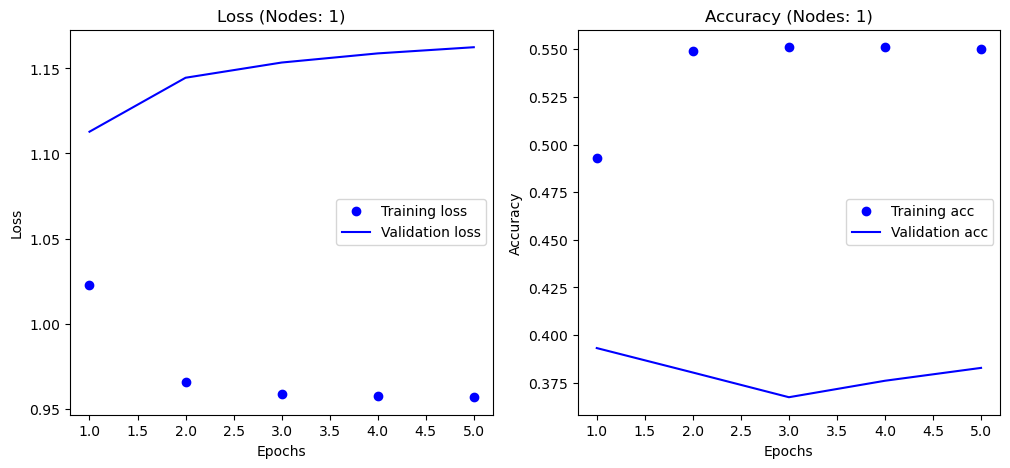


Training with 2 nodes in the hidden layer:
Epoch 1/5
1822/1822 [==============================] - 8s 4ms/step - loss: 1.0004 - accuracy: 0.5205 - val_loss: 1.1629 - val_accuracy: 0.3666
Epoch 2/5
1822/1822 [==============================] - 7s 4ms/step - loss: 0.9578 - accuracy: 0.5604 - val_loss: 1.1837 - val_accuracy: 0.3573
Epoch 3/5
1822/1822 [==============================] - 6s 3ms/step - loss: 0.9376 - accuracy: 0.5688 - val_loss: 1.1928 - val_accuracy: 0.3529
Epoch 4/5
1822/1822 [==============================] - 6s 4ms/step - loss: 0.8904 - accuracy: 0.6022 - val_loss: 1.2250 - val_accuracy: 0.3554
Epoch 5/5
1822/1822 [==============================] - 7s 4ms/step - loss: 0.8707 - accuracy: 0.6116 - val_loss: 1.2473 - val_accuracy: 0.3553


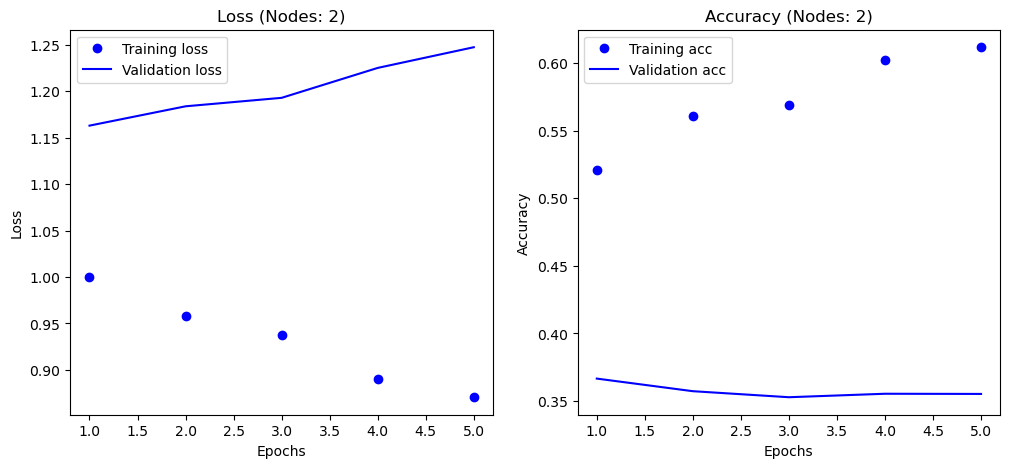


Training with 4 nodes in the hidden layer:
Epoch 1/5
1822/1822 [==============================] - 8s 4ms/step - loss: 0.9596 - accuracy: 0.5310 - val_loss: 1.1820 - val_accuracy: 0.3581
Epoch 2/5
1822/1822 [==============================] - 7s 4ms/step - loss: 0.8746 - accuracy: 0.6106 - val_loss: 1.2367 - val_accuracy: 0.3473
Epoch 3/5
1822/1822 [==============================] - 6s 4ms/step - loss: 0.8649 - accuracy: 0.6137 - val_loss: 1.2577 - val_accuracy: 0.3422
Epoch 4/5
1822/1822 [==============================] - 6s 3ms/step - loss: 0.8618 - accuracy: 0.6157 - val_loss: 1.2557 - val_accuracy: 0.3442
Epoch 5/5
1822/1822 [==============================] - 6s 3ms/step - loss: 0.8593 - accuracy: 0.6177 - val_loss: 1.2531 - val_accuracy: 0.3461


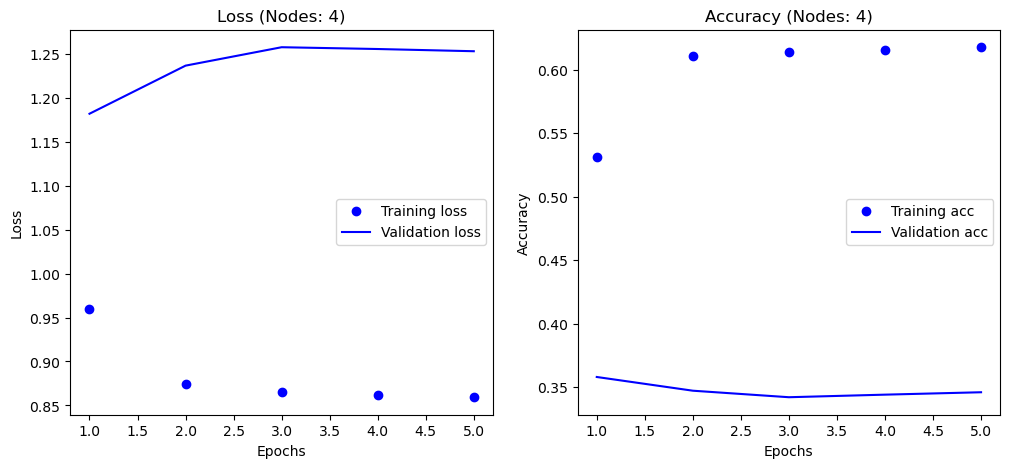


Training with 8 nodes in the hidden layer:
Epoch 1/5
1822/1822 [==============================] - 8s 4ms/step - loss: 0.9152 - accuracy: 0.5771 - val_loss: 1.2393 - val_accuracy: 0.3348
Epoch 2/5
1822/1822 [==============================] - 6s 3ms/step - loss: 0.8650 - accuracy: 0.6129 - val_loss: 1.2413 - val_accuracy: 0.3390
Epoch 3/5
1822/1822 [==============================] - 7s 4ms/step - loss: 0.8592 - accuracy: 0.6151 - val_loss: 1.2407 - val_accuracy: 0.3365
Epoch 4/5
1822/1822 [==============================] - 6s 3ms/step - loss: 0.8542 - accuracy: 0.6173 - val_loss: 1.2287 - val_accuracy: 0.3404
Epoch 5/5
1822/1822 [==============================] - 5s 3ms/step - loss: 0.8493 - accuracy: 0.6191 - val_loss: 1.2184 - val_accuracy: 0.3433


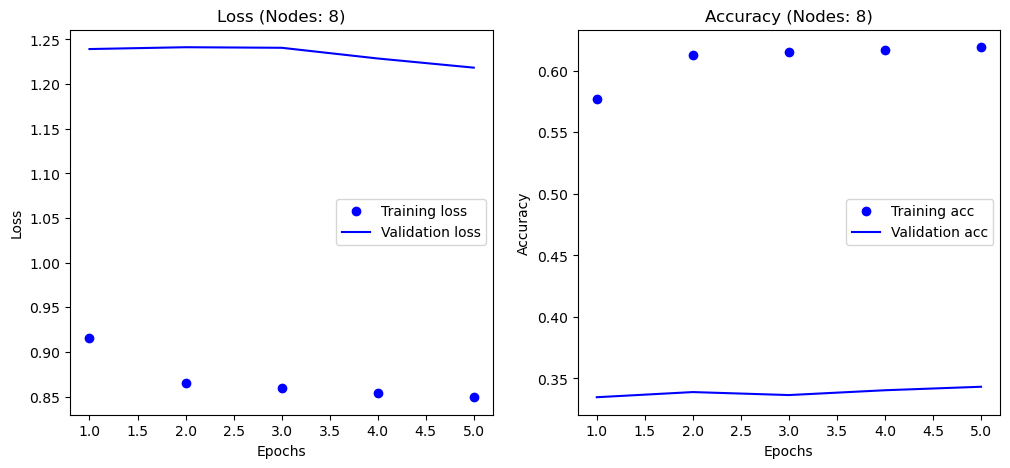


Training with 16 nodes in the hidden layer:
Epoch 1/5
1822/1822 [==============================] - 10s 5ms/step - loss: 0.9069 - accuracy: 0.5834 - val_loss: 1.2412 - val_accuracy: 0.3481
Epoch 2/5
1822/1822 [==============================] - 6s 3ms/step - loss: 0.8619 - accuracy: 0.6141 - val_loss: 1.2538 - val_accuracy: 0.3426
Epoch 3/5
1822/1822 [==============================] - 6s 3ms/step - loss: 0.8539 - accuracy: 0.6193 - val_loss: 1.2508 - val_accuracy: 0.3390
Epoch 4/5
1822/1822 [==============================] - 6s 3ms/step - loss: 0.8460 - accuracy: 0.6234 - val_loss: 1.2590 - val_accuracy: 0.3340
Epoch 5/5
1822/1822 [==============================] - 6s 3ms/step - loss: 0.8375 - accuracy: 0.6288 - val_loss: 1.2674 - val_accuracy: 0.3303


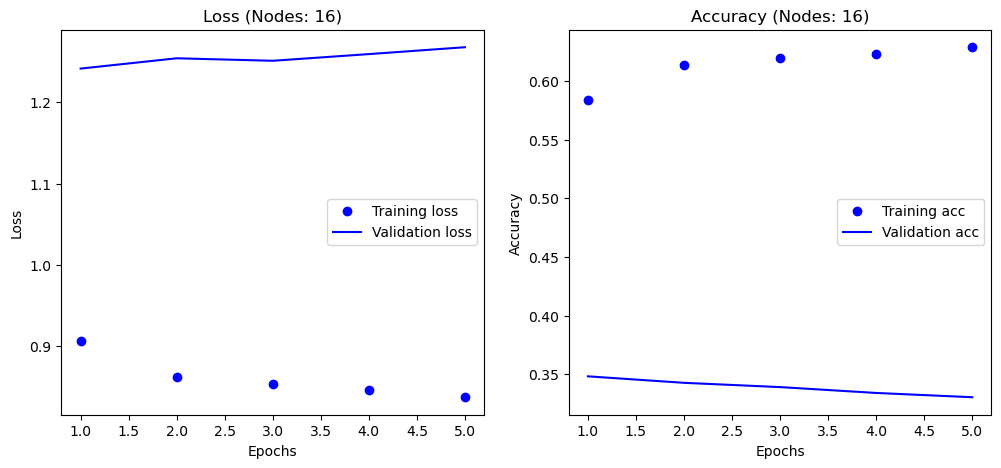


Training with 32 nodes in the hidden layer:
Epoch 1/5
1822/1822 [==============================] - 9s 4ms/step - loss: 0.8999 - accuracy: 0.5883 - val_loss: 1.2354 - val_accuracy: 0.3465
Epoch 2/5
1822/1822 [==============================] - 6s 3ms/step - loss: 0.8550 - accuracy: 0.6167 - val_loss: 1.2454 - val_accuracy: 0.3354
Epoch 3/5
1822/1822 [==============================] - 7s 4ms/step - loss: 0.8336 - accuracy: 0.6309 - val_loss: 1.2476 - val_accuracy: 0.3340
Epoch 4/5
1822/1822 [==============================] - 7s 4ms/step - loss: 0.8112 - accuracy: 0.6427 - val_loss: 1.2446 - val_accuracy: 0.3377
Epoch 5/5
1822/1822 [==============================] - 7s 4ms/step - loss: 0.7926 - accuracy: 0.6533 - val_loss: 1.2768 - val_accuracy: 0.3329


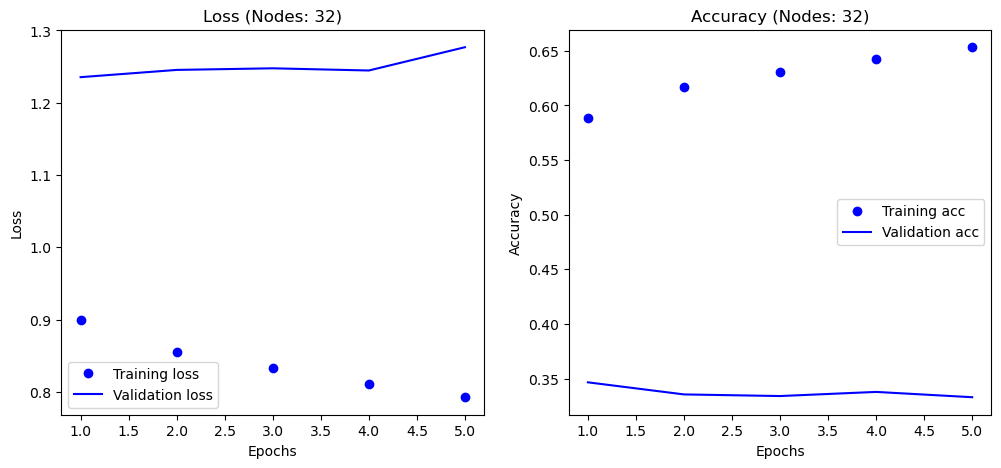


Training with 64 nodes in the hidden layer:
Epoch 1/5
1822/1822 [==============================] - 8s 4ms/step - loss: 0.8924 - accuracy: 0.5909 - val_loss: 1.2624 - val_accuracy: 0.3299
Epoch 2/5
1822/1822 [==============================] - 7s 4ms/step - loss: 0.8525 - accuracy: 0.6196 - val_loss: 1.2350 - val_accuracy: 0.3410
Epoch 3/5
1822/1822 [==============================] - 6s 3ms/step - loss: 0.8267 - accuracy: 0.6351 - val_loss: 1.2639 - val_accuracy: 0.3361
Epoch 4/5
1822/1822 [==============================] - 7s 4ms/step - loss: 0.7945 - accuracy: 0.6531 - val_loss: 1.2713 - val_accuracy: 0.3361
Epoch 5/5
1822/1822 [==============================] - 6s 3ms/step - loss: 0.7646 - accuracy: 0.6697 - val_loss: 1.3194 - val_accuracy: 0.3245


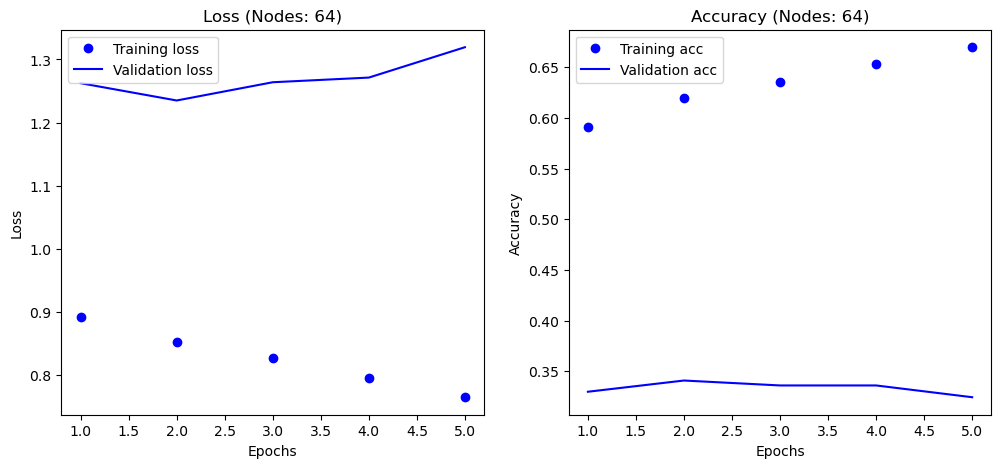


Training with 128 nodes in the hidden layer:
Epoch 1/5
1822/1822 [==============================] - 8s 3ms/step - loss: 0.8890 - accuracy: 0.5952 - val_loss: 1.2465 - val_accuracy: 0.3404
Epoch 2/5
1822/1822 [==============================] - 6s 3ms/step - loss: 0.8355 - accuracy: 0.6297 - val_loss: 1.2626 - val_accuracy: 0.3394
Epoch 3/5
1822/1822 [==============================] - 6s 4ms/step - loss: 0.7862 - accuracy: 0.6571 - val_loss: 1.2879 - val_accuracy: 0.3322
Epoch 4/5
1822/1822 [==============================] - 7s 4ms/step - loss: 0.7422 - accuracy: 0.6805 - val_loss: 1.3415 - val_accuracy: 0.3336
Epoch 5/5
1822/1822 [==============================] - 7s 4ms/step - loss: 0.7056 - accuracy: 0.6983 - val_loss: 1.3820 - val_accuracy: 0.3372


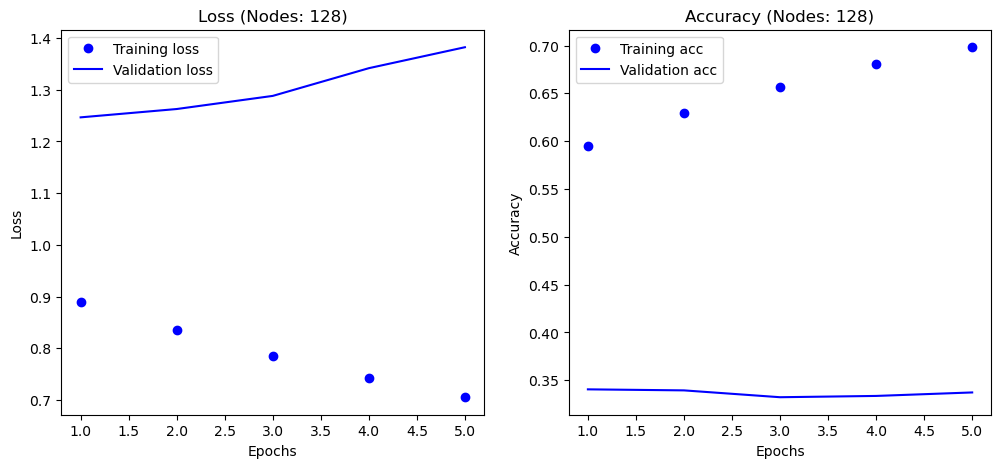


Training with 256 nodes in the hidden layer:
Epoch 1/5
1822/1822 [==============================] - 9s 4ms/step - loss: 0.8849 - accuracy: 0.5990 - val_loss: 1.2345 - val_accuracy: 0.3452
Epoch 2/5
1822/1822 [==============================] - 7s 4ms/step - loss: 0.8230 - accuracy: 0.6383 - val_loss: 1.2666 - val_accuracy: 0.3494
Epoch 3/5
1822/1822 [==============================] - 7s 4ms/step - loss: 0.7579 - accuracy: 0.6739 - val_loss: 1.3035 - val_accuracy: 0.3392
Epoch 4/5
1822/1822 [==============================] - 7s 4ms/step - loss: 0.6982 - accuracy: 0.7040 - val_loss: 1.3474 - val_accuracy: 0.3334
Epoch 5/5
1822/1822 [==============================] - 8s 4ms/step - loss: 0.6419 - accuracy: 0.7327 - val_loss: 1.4261 - val_accuracy: 0.3363


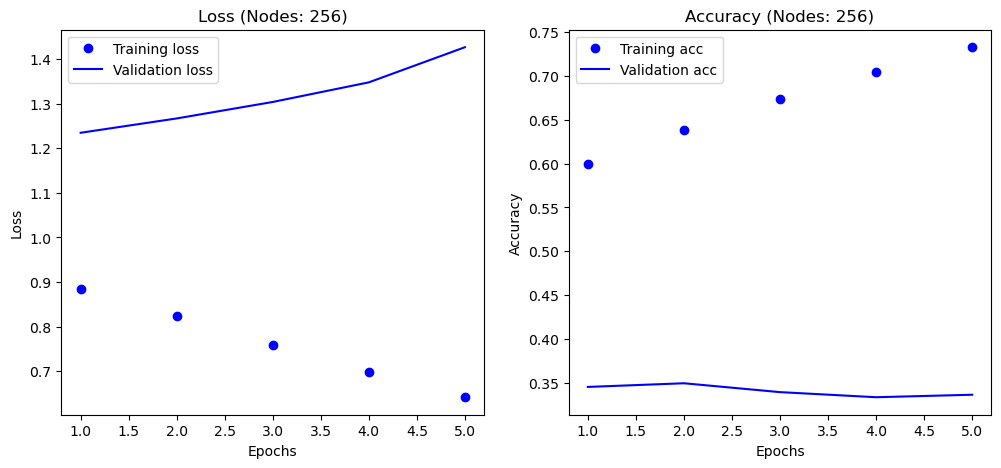


Training with 512 nodes in the hidden layer:
Epoch 1/5
1822/1822 [==============================] - 9s 5ms/step - loss: 0.8817 - accuracy: 0.5988 - val_loss: 1.2440 - val_accuracy: 0.3415
Epoch 2/5
1822/1822 [==============================] - 9s 5ms/step - loss: 0.8030 - accuracy: 0.6491 - val_loss: 1.2752 - val_accuracy: 0.3383
Epoch 3/5
1822/1822 [==============================] - 8s 4ms/step - loss: 0.7279 - accuracy: 0.6878 - val_loss: 1.3536 - val_accuracy: 0.3302
Epoch 4/5
1822/1822 [==============================] - 7s 4ms/step - loss: 0.6437 - accuracy: 0.7316 - val_loss: 1.4173 - val_accuracy: 0.3417
Epoch 5/5
1822/1822 [==============================] - 8s 5ms/step - loss: 0.5616 - accuracy: 0.7718 - val_loss: 1.5894 - val_accuracy: 0.3321


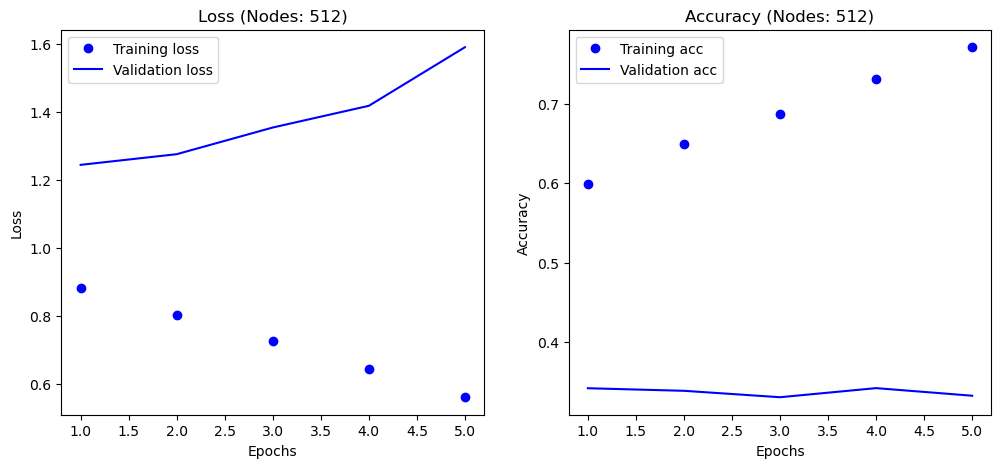

In [41]:
# Function to create and compile the neural network model
def create_model(n_nodes, input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))  # Explicit input layer
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(3, activation='softmax'))  # Assuming 3 output classes
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Function to plot the training history
def plot_history(history, n_nodes):
    epochs = range(1, len(history.history['loss']) + 1)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
    plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
    plt.title(f'Loss (Nodes: {n_nodes})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], 'bo', label='Training acc')
    plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation acc')
    plt.title(f'Accuracy (Nodes: {n_nodes})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Function to run the experiment
def run_experiment(X_train, y_train, X_valid, y_valid, n_nodes, epochs=50):
    model = create_model(n_nodes, input_shape=(X_train.shape[1],))
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_valid, y_valid))
    plot_history(history, n_nodes)
    return history

# List of node configurations to test
node_configurations = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]

# Running the experiment for each configuration
for n_nodes in node_configurations:
    print(f"\nTraining with {n_nodes} nodes in the hidden layer:")
    history = run_experiment(X_train, y_train, X_valid, y_valid, n_nodes, epochs=5)

**Thoughts:** As the number of nodes increases, the loss decreases exponentially. Thus for the evaluation of more epochs, I will only be running the 512 and 256 node developments.


Training with 256 nodes in the hidden layer:
Epoch 1/20
1822/1822 [==============================] - 9s 4ms/step - loss: 0.8845 - accuracy: 0.5963 - val_loss: 1.2530 - val_accuracy: 0.3383
Epoch 2/20
1822/1822 [==============================] - 8s 4ms/step - loss: 0.8219 - accuracy: 0.6380 - val_loss: 1.2802 - val_accuracy: 0.3294
Epoch 3/20
1822/1822 [==============================] - 7s 4ms/step - loss: 0.7573 - accuracy: 0.6739 - val_loss: 1.3341 - val_accuracy: 0.3214
Epoch 4/20
1822/1822 [==============================] - 7s 4ms/step - loss: 0.6980 - accuracy: 0.7048 - val_loss: 1.3688 - val_accuracy: 0.3336
Epoch 5/20
1822/1822 [==============================] - 7s 4ms/step - loss: 0.6419 - accuracy: 0.7345 - val_loss: 1.4003 - val_accuracy: 0.3446
Epoch 6/20
1822/1822 [==============================] - 7s 4ms/step - loss: 0.5886 - accuracy: 0.7580 - val_loss: 1.5206 - val_accuracy: 0.3354
Epoch 7/20
1822/1822 [==============================] - 7s 4ms/step - loss: 0.5409 - accur

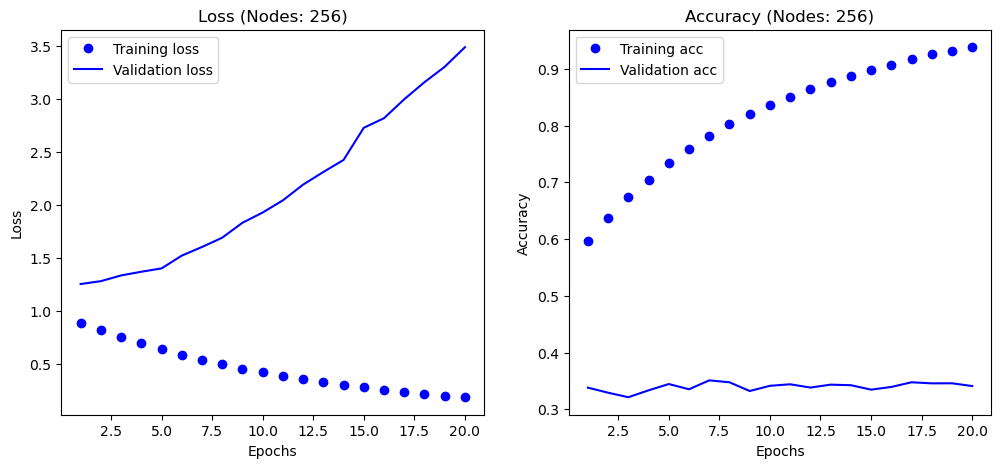


Training with 512 nodes in the hidden layer:
Epoch 1/20
1822/1822 [==============================] - 9s 4ms/step - loss: 0.8810 - accuracy: 0.6022 - val_loss: 1.2261 - val_accuracy: 0.3518
Epoch 2/20
1822/1822 [==============================] - 8s 4ms/step - loss: 0.8036 - accuracy: 0.6484 - val_loss: 1.2617 - val_accuracy: 0.3476
Epoch 3/20
1822/1822 [==============================] - 7s 4ms/step - loss: 0.7235 - accuracy: 0.6902 - val_loss: 1.3463 - val_accuracy: 0.3273
Epoch 4/20
1822/1822 [==============================] - 7s 4ms/step - loss: 0.6406 - accuracy: 0.7339 - val_loss: 1.4021 - val_accuracy: 0.3444
Epoch 5/20
1822/1822 [==============================] - 7s 4ms/step - loss: 0.5585 - accuracy: 0.7750 - val_loss: 1.5163 - val_accuracy: 0.3468
Epoch 6/20
1822/1822 [==============================] - 7s 4ms/step - loss: 0.4816 - accuracy: 0.8104 - val_loss: 1.7097 - val_accuracy: 0.3384
Epoch 7/20
1822/1822 [==============================] - 7s 4ms/step - loss: 0.4135 - accur

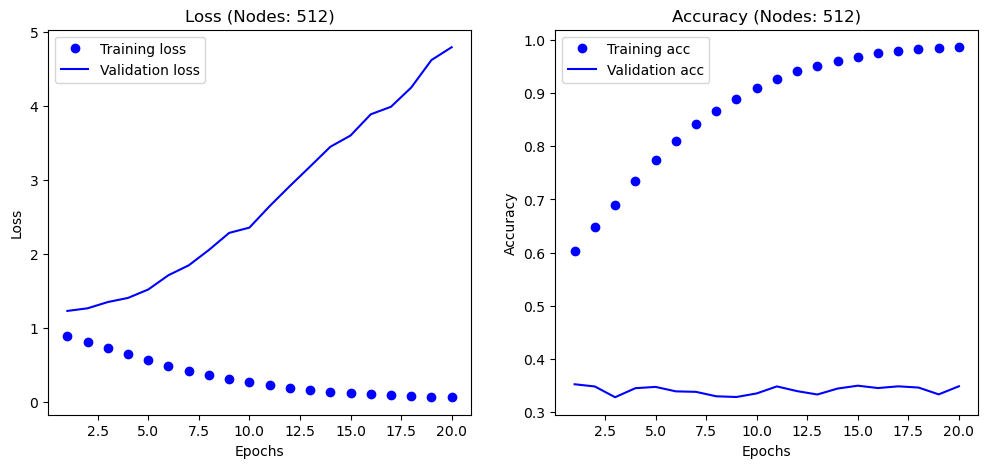

In [42]:
# List of node configurations to test
node_configurations = [256, 512]

# Running the experiment for each configuration
for n_nodes in node_configurations:
    print(f"\nTraining with {n_nodes} nodes in the hidden layer:")
    history = run_experiment(X_train, y_train, X_valid, y_valid, n_nodes, epochs=20)

    - **Varying the number of layers**.

        - Conduct similar experiments as described above, but this time vary the number of layers from 1 to 4. Document your findings.

        - How many nodes should each layer contain? Test at least two scenarios. Traditionally, a common strategy involved decreasing the number of nodes from the input layer to the output layer, often by halving, to create a pyramid-like structure. However, recent experience suggests that maintaining a constant number of nodes across all layers can perform equally well. Describe your observations. It is acceptable if both strategies yield similar performance results.

        - Select one your models that exemplifies overfitting. In our experiments, we easily constructed a model achieving nearly 100% accuracy on the training data, yet showing no similar improvement on the validation set. Present this neural network along with its accuracy and loss graphs. Explain the reasoning for concluding that the model is overfitting.

Testing Pyramid Configuration:

Training with layers: [64]
Epoch 1/5
1822/1822 [==============================] - 8s 4ms/step - loss: 0.8919 - accuracy: 0.5935 - val_loss: 1.2394 - val_accuracy: 0.3456
Epoch 2/5
1822/1822 [==============================] - 6s 3ms/step - loss: 0.8482 - accuracy: 0.6219 - val_loss: 1.2449 - val_accuracy: 0.3467
Epoch 3/5
1822/1822 [==============================] - 6s 3ms/step - loss: 0.8164 - accuracy: 0.6399 - val_loss: 1.2762 - val_accuracy: 0.3338
Epoch 4/5
1822/1822 [==============================] - 6s 3ms/step - loss: 0.7825 - accuracy: 0.6601 - val_loss: 1.2809 - val_accuracy: 0.3440
Epoch 5/5
1822/1822 [==============================] - 6s 3ms/step - loss: 0.7536 - accuracy: 0.6763 - val_loss: 1.3256 - val_accuracy: 0.3367


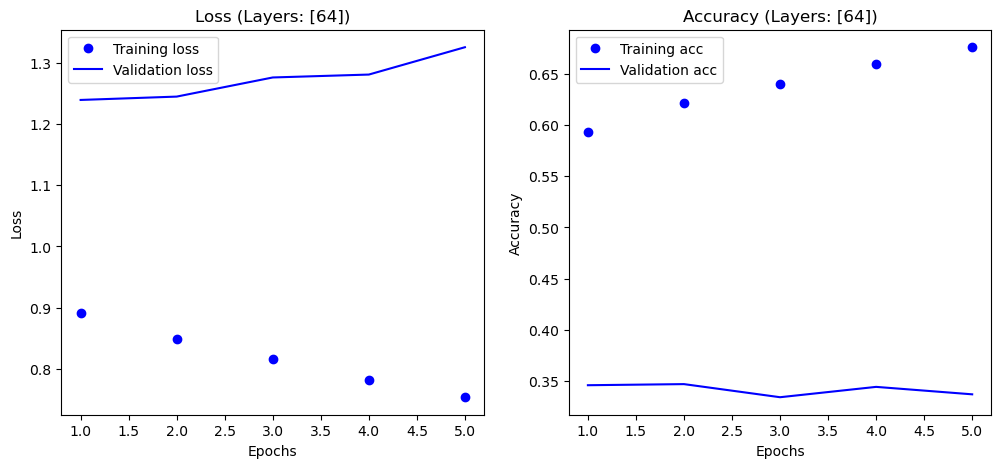


Training with layers: [64, 32]
Epoch 1/5
1822/1822 [==============================] - 8s 4ms/step - loss: 0.8898 - accuracy: 0.5916 - val_loss: 1.2620 - val_accuracy: 0.3323
Epoch 2/5
1822/1822 [==============================] - 7s 4ms/step - loss: 0.8350 - accuracy: 0.6285 - val_loss: 1.2643 - val_accuracy: 0.3356
Epoch 3/5
1822/1822 [==============================] - 7s 4ms/step - loss: 0.7921 - accuracy: 0.6500 - val_loss: 1.2959 - val_accuracy: 0.3276
Epoch 4/5
1822/1822 [==============================] - 7s 4ms/step - loss: 0.7566 - accuracy: 0.6697 - val_loss: 1.3417 - val_accuracy: 0.3213
Epoch 5/5
1822/1822 [==============================] - 7s 4ms/step - loss: 0.7268 - accuracy: 0.6841 - val_loss: 1.4030 - val_accuracy: 0.3295


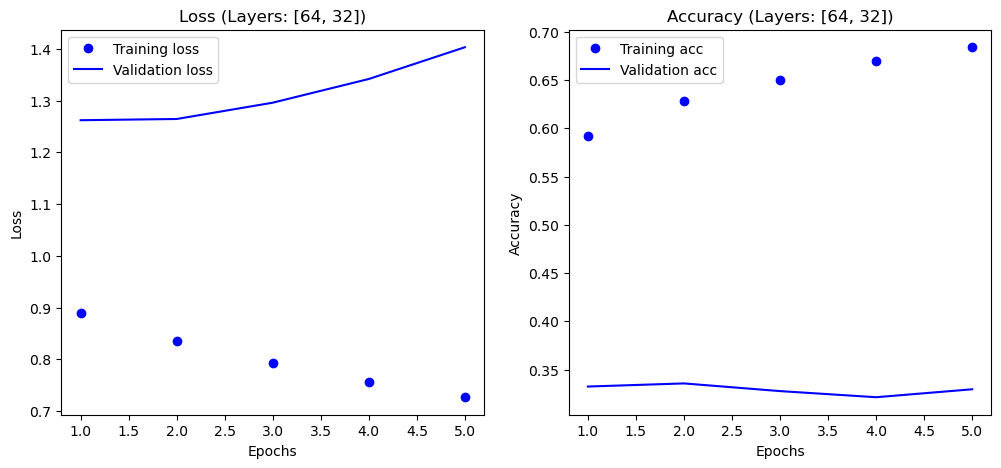


Training with layers: [64, 32, 16]
Epoch 1/5
1822/1822 [==============================] - 8s 4ms/step - loss: 0.8916 - accuracy: 0.5902 - val_loss: 1.2710 - val_accuracy: 0.3248
Epoch 2/5
1822/1822 [==============================] - 7s 4ms/step - loss: 0.8326 - accuracy: 0.6269 - val_loss: 1.2776 - val_accuracy: 0.3321
Epoch 3/5
1822/1822 [==============================] - 7s 4ms/step - loss: 0.7873 - accuracy: 0.6523 - val_loss: 1.3218 - val_accuracy: 0.3398
Epoch 4/5
1822/1822 [==============================] - 7s 4ms/step - loss: 0.7503 - accuracy: 0.6729 - val_loss: 1.3582 - val_accuracy: 0.3288
Epoch 5/5
1822/1822 [==============================] - 7s 4ms/step - loss: 0.7214 - accuracy: 0.6865 - val_loss: 1.4444 - val_accuracy: 0.3280


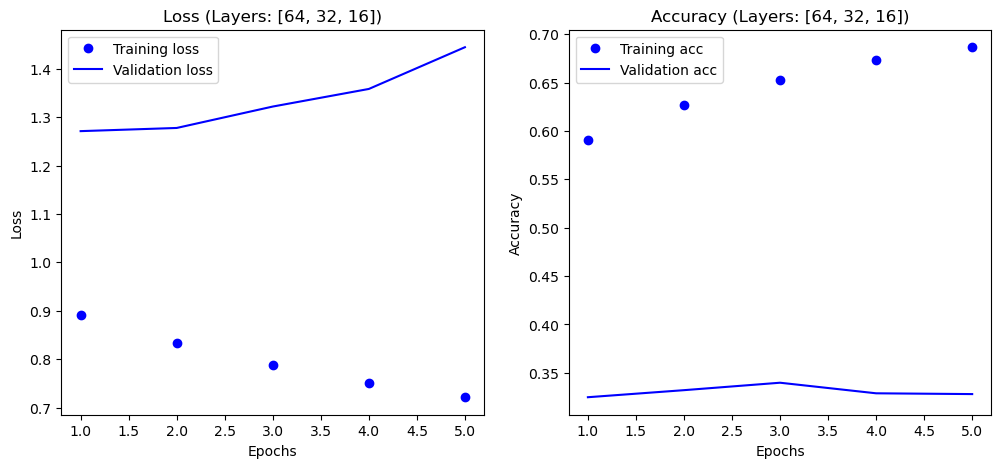


Training with layers: [64, 32, 16, 8]
Epoch 1/5
1822/1822 [==============================] - 9s 4ms/step - loss: 0.9045 - accuracy: 0.5829 - val_loss: 1.2771 - val_accuracy: 0.3360
Epoch 2/5
1822/1822 [==============================] - 7s 4ms/step - loss: 0.8392 - accuracy: 0.6258 - val_loss: 1.2639 - val_accuracy: 0.3323
Epoch 3/5
1822/1822 [==============================] - 7s 4ms/step - loss: 0.7975 - accuracy: 0.6498 - val_loss: 1.2803 - val_accuracy: 0.3345
Epoch 4/5
1822/1822 [==============================] - 7s 4ms/step - loss: 0.7579 - accuracy: 0.6705 - val_loss: 1.3469 - val_accuracy: 0.3290
Epoch 5/5
1822/1822 [==============================] - 8s 4ms/step - loss: 0.7277 - accuracy: 0.6849 - val_loss: 1.4092 - val_accuracy: 0.3222


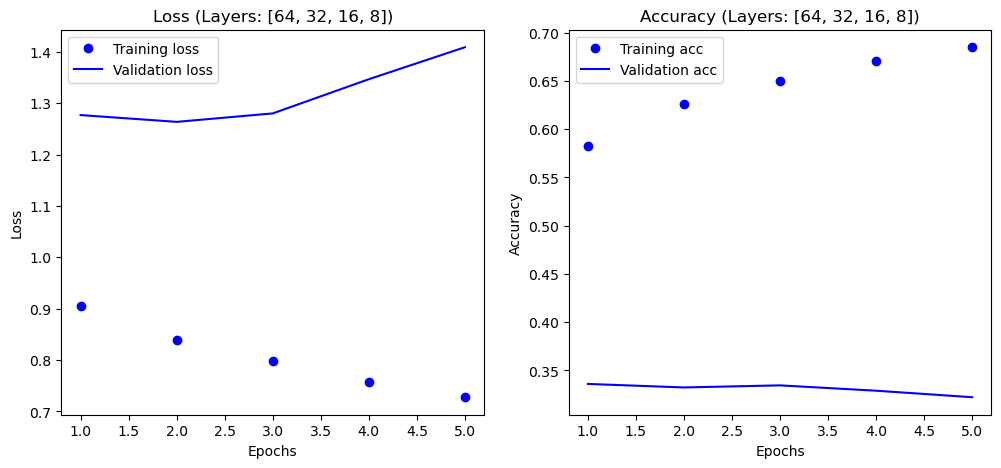

Testing Constant Node Configuration:

Training with layers: [64]
Epoch 1/5
1822/1822 [==============================] - 9s 4ms/step - loss: 0.8940 - accuracy: 0.5923 - val_loss: 1.2604 - val_accuracy: 0.3299
Epoch 2/5
1822/1822 [==============================] - 7s 4ms/step - loss: 0.8516 - accuracy: 0.6197 - val_loss: 1.2467 - val_accuracy: 0.3348
Epoch 3/5
1822/1822 [==============================] - 7s 4ms/step - loss: 0.8262 - accuracy: 0.6350 - val_loss: 1.2762 - val_accuracy: 0.3314
Epoch 4/5
1822/1822 [==============================] - 7s 4ms/step - loss: 0.7972 - accuracy: 0.6511 - val_loss: 1.2908 - val_accuracy: 0.3238
Epoch 5/5
1822/1822 [==============================] - 7s 4ms/step - loss: 0.7671 - accuracy: 0.6676 - val_loss: 1.3194 - val_accuracy: 0.3400


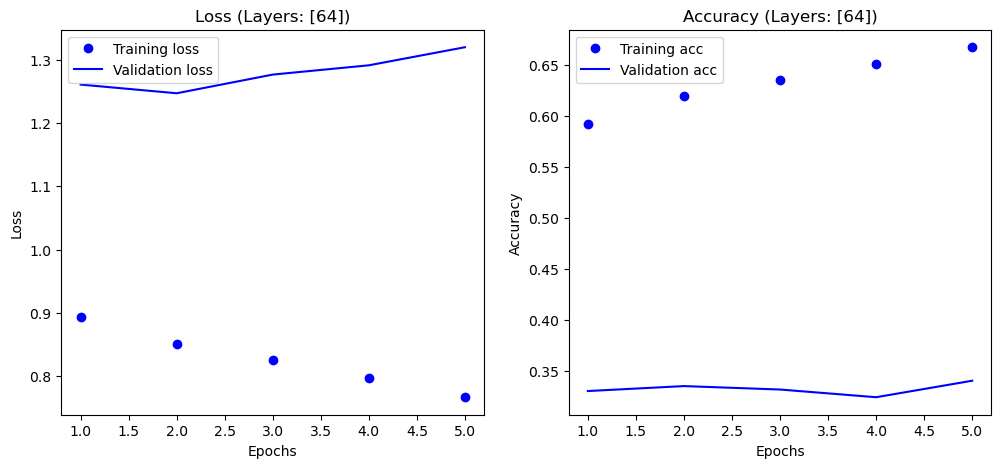


Training with layers: [64, 64]
Epoch 1/5
1822/1822 [==============================] - 8s 4ms/step - loss: 0.8910 - accuracy: 0.5910 - val_loss: 1.2024 - val_accuracy: 0.3457
Epoch 2/5
1822/1822 [==============================] - 7s 4ms/step - loss: 0.8344 - accuracy: 0.6277 - val_loss: 1.2574 - val_accuracy: 0.3344
Epoch 3/5
1822/1822 [==============================] - 7s 4ms/step - loss: 0.7874 - accuracy: 0.6530 - val_loss: 1.3086 - val_accuracy: 0.3372
Epoch 4/5
1822/1822 [==============================] - 7s 4ms/step - loss: 0.7468 - accuracy: 0.6726 - val_loss: 1.3263 - val_accuracy: 0.3364
Epoch 5/5
1822/1822 [==============================] - 7s 4ms/step - loss: 0.7179 - accuracy: 0.6874 - val_loss: 1.3697 - val_accuracy: 0.3423


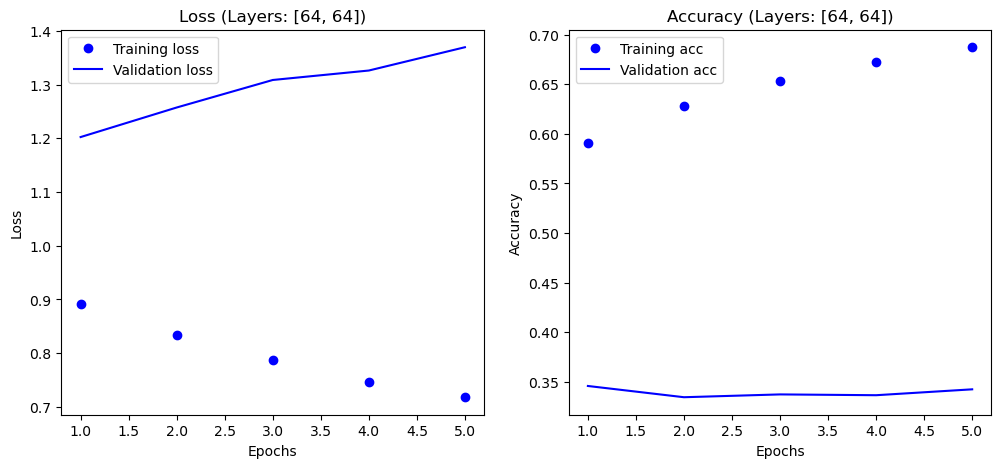


Training with layers: [64, 64, 64]
Epoch 1/5
1822/1822 [==============================] - 9s 4ms/step - loss: 0.8902 - accuracy: 0.5898 - val_loss: 1.2556 - val_accuracy: 0.3330
Epoch 2/5
1822/1822 [==============================] - 8s 4ms/step - loss: 0.8286 - accuracy: 0.6326 - val_loss: 1.2693 - val_accuracy: 0.3402
Epoch 3/5
1822/1822 [==============================] - 8s 4ms/step - loss: 0.7784 - accuracy: 0.6576 - val_loss: 1.2522 - val_accuracy: 0.3417
Epoch 4/5
1822/1822 [==============================] - 8s 4ms/step - loss: 0.7391 - accuracy: 0.6778 - val_loss: 1.3539 - val_accuracy: 0.3317
Epoch 5/5
1822/1822 [==============================] - 8s 4ms/step - loss: 0.7064 - accuracy: 0.6944 - val_loss: 1.4607 - val_accuracy: 0.3329


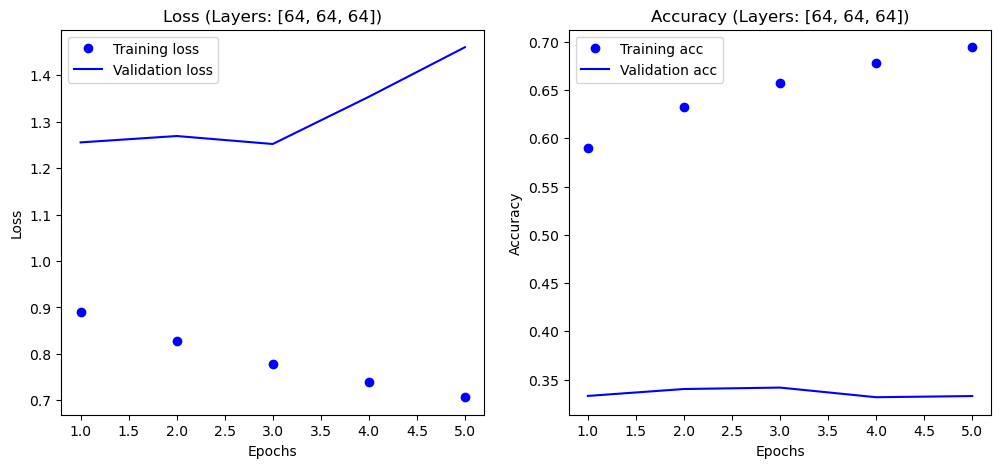


Training with layers: [64, 64, 64, 64]
Epoch 1/5
1822/1822 [==============================] - 10s 5ms/step - loss: 0.8895 - accuracy: 0.5915 - val_loss: 1.2387 - val_accuracy: 0.3442
Epoch 2/5
1822/1822 [==============================] - 8s 5ms/step - loss: 0.8315 - accuracy: 0.6287 - val_loss: 1.3032 - val_accuracy: 0.3325
Epoch 3/5
1822/1822 [==============================] - 8s 5ms/step - loss: 0.7811 - accuracy: 0.6563 - val_loss: 1.3361 - val_accuracy: 0.3236
Epoch 4/5
1822/1822 [==============================] - 9s 5ms/step - loss: 0.7403 - accuracy: 0.6760 - val_loss: 1.3682 - val_accuracy: 0.3255
Epoch 5/5
1822/1822 [==============================] - 8s 5ms/step - loss: 0.7081 - accuracy: 0.6920 - val_loss: 1.5224 - val_accuracy: 0.3168


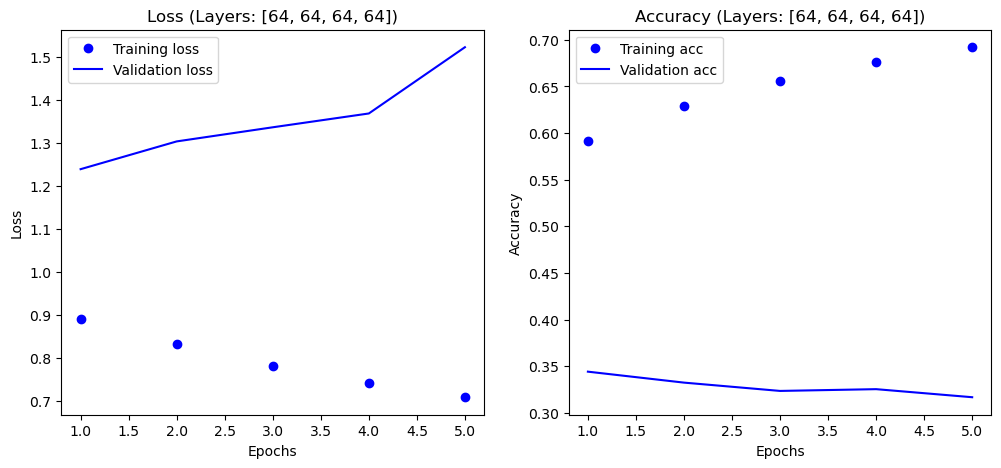

In [43]:
# Function to create and compile the neural network model
def create_model(layer_config, input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))  # Explicit input layer
    for nodes in layer_config:
        model.add(Dense(nodes, activation='relu'))
    model.add(Dense(3, activation='softmax'))  # Assuming 3 output classes
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Function to plot the training history
def plot_history(history, layer_config):
    epochs = range(1, len(history.history['loss']) + 1)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
    plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
    plt.title(f'Loss (Layers: {layer_config})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], 'bo', label='Training acc')
    plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation acc')
    plt.title(f'Accuracy (Layers: {layer_config})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Function to run the experiment
def run_experiment(X_train, y_train, X_valid, y_valid, layer_config, epochs=50):
    model = create_model(layer_config, input_shape=(X_train.shape[1],))
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_valid, y_valid))
    plot_history(history, layer_config)
    return history

# Define layer configurations
layer_configs_pyramid = [
    [64],        # 1 layer
    [64, 32],    # 2 layers
    [64, 32, 16],# 3 layers
    [64, 32, 16, 8] # 4 layers
]

layer_configs_constant = [
    [64],        # 1 layer
    [64, 64],    # 2 layers
    [64, 64, 64],# 3 layers
    [64, 64, 64, 64] # 4 layers
]

# Running the experiment for pyramid configuration
print("Testing Pyramid Configuration:")
for config in layer_configs_pyramid:
    print(f"\nTraining with layers: {config}")
    history = run_experiment(X_train, y_train, X_valid, y_valid, config, epochs=5)

# Running the experiment for constant configuration
print("Testing Constant Node Configuration:")
for config in layer_configs_constant:
    print(f"\nTraining with layers: {config}")
    history = run_experiment(X_train, y_train, X_valid, y_valid, config, epochs=5)


    - **Activation function**.

        - Present results for one of the configurations mentioned above by varying the activation function. Test at least `relu` (the default) and `sigmoid`. The choice of the specific model, including the number of layers and nodes, is at your discretion. Document your observations accordingly.

Testing with activation function 'relu'
Epoch 1/20
1822/1822 [==============================] - 9s 4ms/step - loss: 0.8927 - accuracy: 0.5897 - val_loss: 1.2521 - val_accuracy: 0.3500
Epoch 2/20
1822/1822 [==============================] - 8s 4ms/step - loss: 0.8353 - accuracy: 0.6245 - val_loss: 1.2646 - val_accuracy: 0.3307
Epoch 3/20
1822/1822 [==============================] - 8s 4ms/step - loss: 0.7897 - accuracy: 0.6489 - val_loss: 1.3507 - val_accuracy: 0.3284
Epoch 4/20
1822/1822 [==============================] - 9s 5ms/step - loss: 0.7498 - accuracy: 0.6694 - val_loss: 1.3706 - val_accuracy: 0.3248
Epoch 5/20
1822/1822 [==============================] - 9s 5ms/step - loss: 0.7178 - accuracy: 0.6860 - val_loss: 1.5074 - val_accuracy: 0.3164
Epoch 6/20
1822/1822 [==============================] - 8s 4ms/step - loss: 0.6908 - accuracy: 0.7005 - val_loss: 1.5250 - val_accuracy: 0.3197
Epoch 7/20
1822/1822 [==============================] - 8s 4ms/step - loss: 0.6678 - accuracy: 0

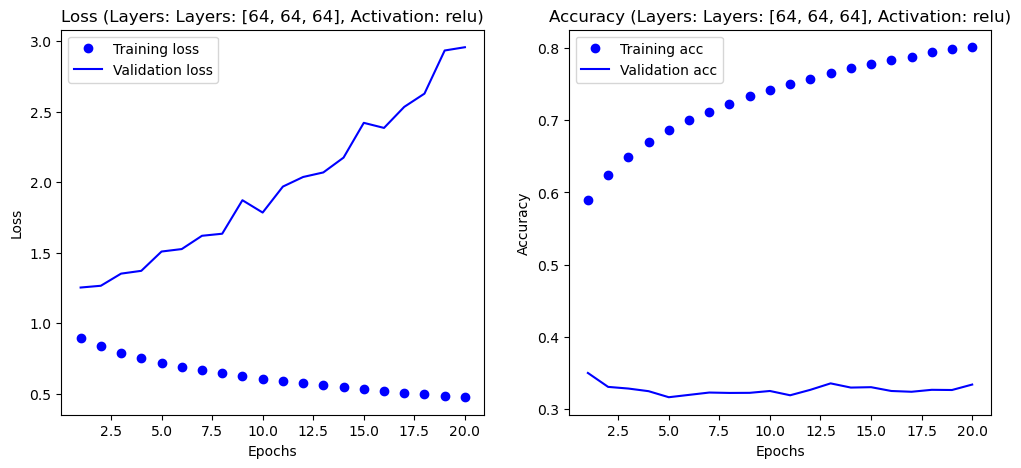

Testing with activation function 'sigmoid'
Epoch 1/20
1822/1822 [==============================] - 10s 5ms/step - loss: 0.9343 - accuracy: 0.5538 - val_loss: 1.2378 - val_accuracy: 0.3430
Epoch 2/20
1822/1822 [==============================] - 8s 4ms/step - loss: 0.8668 - accuracy: 0.6107 - val_loss: 1.2510 - val_accuracy: 0.3510
Epoch 3/20
1822/1822 [==============================] - 8s 4ms/step - loss: 0.8624 - accuracy: 0.6144 - val_loss: 1.2830 - val_accuracy: 0.3333
Epoch 4/20
1822/1822 [==============================] - 8s 4ms/step - loss: 0.8606 - accuracy: 0.6149 - val_loss: 1.2664 - val_accuracy: 0.3384
Epoch 5/20
1822/1822 [==============================] - 8s 4ms/step - loss: 0.8591 - accuracy: 0.6155 - val_loss: 1.2970 - val_accuracy: 0.3280
Epoch 6/20
1822/1822 [==============================] - 8s 4ms/step - loss: 0.8587 - accuracy: 0.6165 - val_loss: 1.2640 - val_accuracy: 0.3406
Epoch 7/20
1822/1822 [==============================] - 8s 5ms/step - loss: 0.8571 - accurac

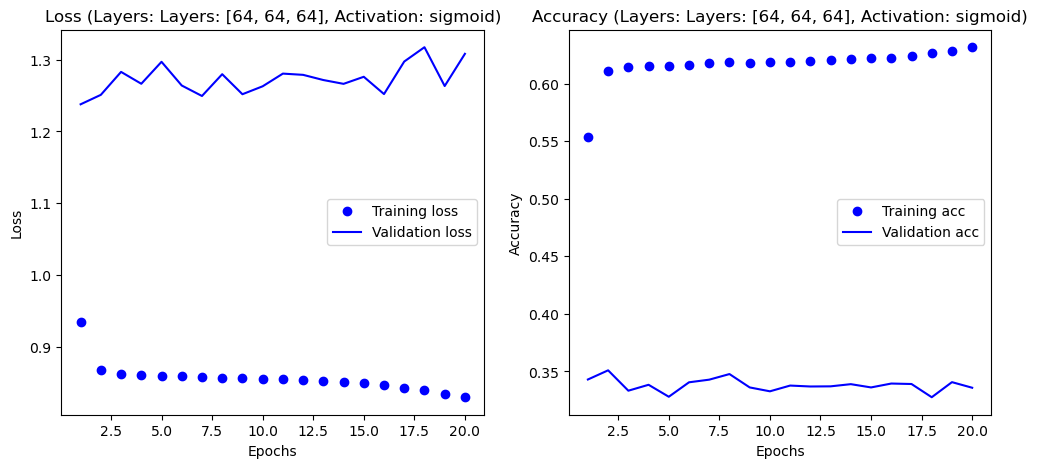

In [44]:
# Modified create_model function to accept activation function as parameter
def create_model(layer_config, input_shape, activation='relu'):
    model = Sequential()
    model.add(Input(shape=input_shape))  # Explicit input layer
    for nodes in layer_config:
        model.add(Dense(nodes, activation=activation))
    model.add(Dense(3, activation='softmax'))  # Output layer
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Function to run the experiment with specified activation function
def run_experiment_activation(X_train, y_train, X_valid, y_valid, layer_config, activation='relu', epochs=20):
    model = create_model(layer_config, input_shape=(X_train.shape[1],), activation=activation)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_valid, y_valid))
    plot_history(history, f"Layers: {layer_config}, Activation: {activation}")
    return history

# Now, let's test with 'relu' and 'sigmoid'
layer_config = [64, 64, 64]  # 3 layers, 64 nodes each

print("Testing with activation function 'relu'")
history_relu = run_experiment_activation(X_train, y_train, X_valid, y_valid, layer_config, activation='relu', epochs=20)

print("Testing with activation function 'sigmoid'")
history_sigmoid = run_experiment_activation(X_train, y_train, X_valid, y_valid, layer_config, activation='sigmoid', epochs=20)

    - **Regularization** in neural networks is a technique used to prevent overfitting.

        - One technique involves adding a penalty to the loss function to discourage excessively complex models. Apply an `l2` penalty to some or all layers. Exercise caution, as overly aggressive penalties have been problematic in our experiments. Begin with the default `l2` value of 0.01, then reduce it to 0.001 and 1e-4. Select a specific model from the above experiments and present a case where you successfully reduced overfitting. Include a pair of graphs comparing results with and without regularization. Explain your rationale to conclude that overfitting has been reduced. Do not expect to completely eliminate overfitting. Again, this is a challenging dataset to work with.

Training without L2 regularization
Epoch 1/20
1822/1822 [==============================] - 12s 6ms/step - loss: 0.8831 - accuracy: 0.5956 - val_loss: 1.2847 - val_accuracy: 0.3383
Epoch 2/20
1822/1822 [==============================] - 10s 5ms/step - loss: 0.7949 - accuracy: 0.6478 - val_loss: 1.3139 - val_accuracy: 0.3361
Epoch 3/20
1822/1822 [==============================] - 9s 5ms/step - loss: 0.7094 - accuracy: 0.6908 - val_loss: 1.5289 - val_accuracy: 0.3182
Epoch 4/20
1822/1822 [==============================] - 10s 5ms/step - loss: 0.6213 - accuracy: 0.7376 - val_loss: 1.6640 - val_accuracy: 0.3375
Epoch 5/20
1822/1822 [==============================] - 10s 5ms/step - loss: 0.5337 - accuracy: 0.7779 - val_loss: 2.0827 - val_accuracy: 0.3278
Epoch 6/20
1822/1822 [==============================] - 9s 5ms/step - loss: 0.4536 - accuracy: 0.8158 - val_loss: 2.6542 - val_accuracy: 0.3230
Epoch 7/20
1822/1822 [==============================] - 9s 5ms/step - loss: 0.3824 - accuracy: 0.

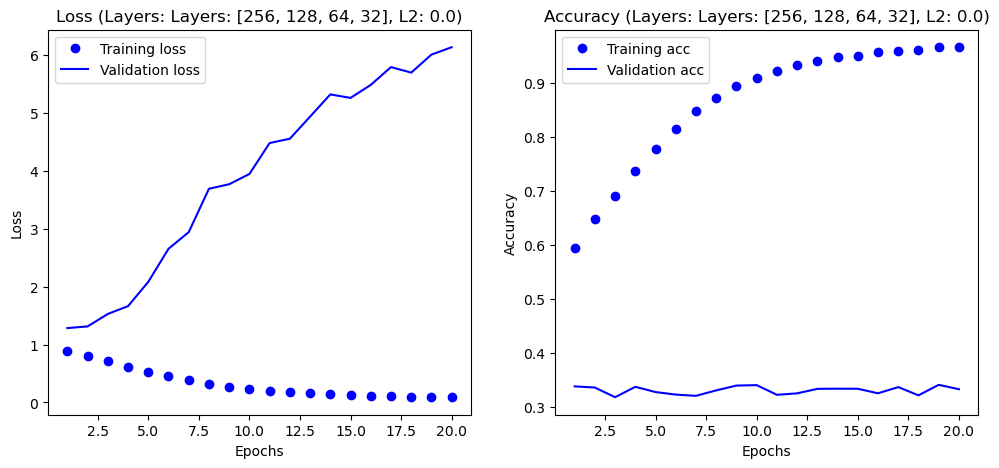


Training with L2 regularization (l2=0.01)
Epoch 1/20
1822/1822 [==============================] - 11s 5ms/step - loss: 1.1874 - accuracy: 0.4654 - val_loss: 1.1744 - val_accuracy: 0.3579
Epoch 2/20
1822/1822 [==============================] - 9s 5ms/step - loss: 1.0291 - accuracy: 0.5050 - val_loss: 1.2079 - val_accuracy: 0.3680
Epoch 3/20
1822/1822 [==============================] - 9s 5ms/step - loss: 1.0217 - accuracy: 0.5134 - val_loss: 1.1932 - val_accuracy: 0.3672
Epoch 4/20
1822/1822 [==============================] - 10s 5ms/step - loss: 1.0171 - accuracy: 0.5176 - val_loss: 1.1846 - val_accuracy: 0.3664
Epoch 5/20
1822/1822 [==============================] - 11s 6ms/step - loss: 1.0122 - accuracy: 0.5210 - val_loss: 1.1963 - val_accuracy: 0.3554
Epoch 6/20
1822/1822 [==============================] - 10s 6ms/step - loss: 1.0091 - accuracy: 0.5254 - val_loss: 1.1910 - val_accuracy: 0.3584
Epoch 7/20
1822/1822 [==============================] - 11s 6ms/step - loss: 1.0061 - acc

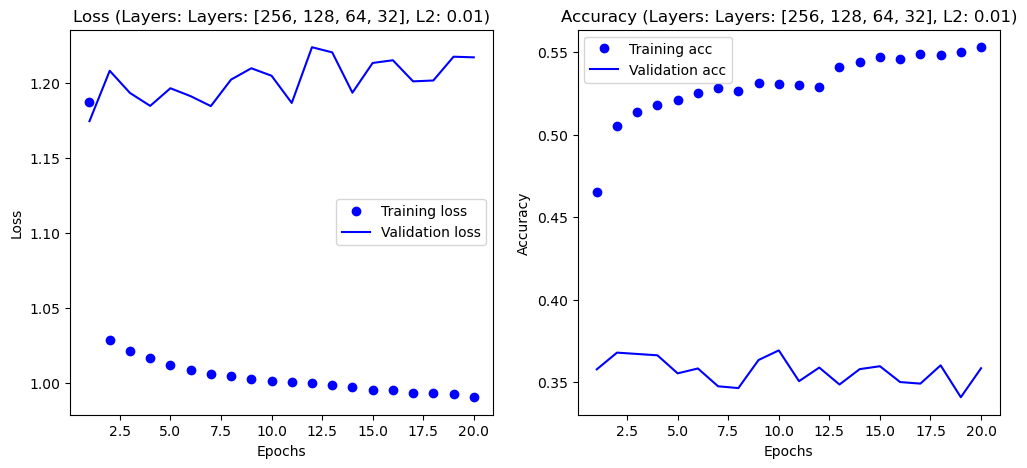


Training with L2 regularization (l2=0.001)
Epoch 1/20
1822/1822 [==============================] - 14s 7ms/step - loss: 1.0241 - accuracy: 0.5921 - val_loss: 1.3068 - val_accuracy: 0.3844
Epoch 2/20
1822/1822 [==============================] - 13s 7ms/step - loss: 0.9069 - accuracy: 0.6242 - val_loss: 1.2805 - val_accuracy: 0.3568
Epoch 3/20
1822/1822 [==============================] - 12s 7ms/step - loss: 0.8767 - accuracy: 0.6406 - val_loss: 1.3172 - val_accuracy: 0.3419
Epoch 4/20
1822/1822 [==============================] - 10s 6ms/step - loss: 0.8581 - accuracy: 0.6510 - val_loss: 1.3641 - val_accuracy: 0.3364
Epoch 5/20
1822/1822 [==============================] - 13s 7ms/step - loss: 0.8460 - accuracy: 0.6593 - val_loss: 1.3270 - val_accuracy: 0.3441
Epoch 6/20
1822/1822 [==============================] - 14s 7ms/step - loss: 0.8376 - accuracy: 0.6655 - val_loss: 1.4021 - val_accuracy: 0.3222
Epoch 7/20
1822/1822 [==============================] - 13s 7ms/step - loss: 0.8286 - 

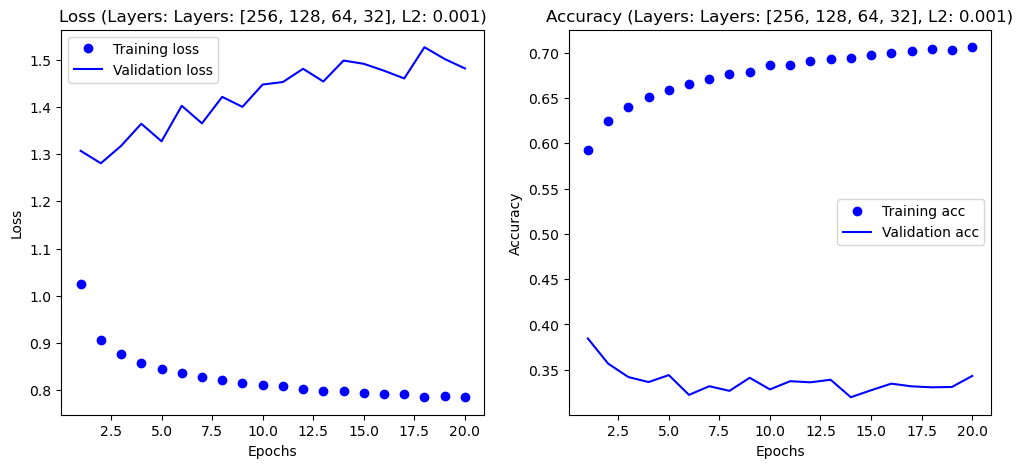


Training with L2 regularization (l2=0.0001)
Epoch 1/20
1822/1822 [==============================] - 16s 8ms/step - loss: 0.9257 - accuracy: 0.5959 - val_loss: 1.3236 - val_accuracy: 0.3341
Epoch 2/20
1822/1822 [==============================] - 14s 8ms/step - loss: 0.8449 - accuracy: 0.6445 - val_loss: 1.3084 - val_accuracy: 0.3417
Epoch 3/20
1822/1822 [==============================] - 15s 8ms/step - loss: 0.7898 - accuracy: 0.6782 - val_loss: 1.3879 - val_accuracy: 0.3318
Epoch 4/20
1822/1822 [==============================] - 18s 10ms/step - loss: 0.7365 - accuracy: 0.7066 - val_loss: 1.5151 - val_accuracy: 0.3284
Epoch 5/20
1822/1822 [==============================] - 19s 10ms/step - loss: 0.6852 - accuracy: 0.7380 - val_loss: 1.6833 - val_accuracy: 0.3342
Epoch 6/20
1822/1822 [==============================] - 23s 13ms/step - loss: 0.6334 - accuracy: 0.7711 - val_loss: 1.7729 - val_accuracy: 0.3322
Epoch 7/20
1822/1822 [==============================] - 23s 13ms/step - loss: 0.58

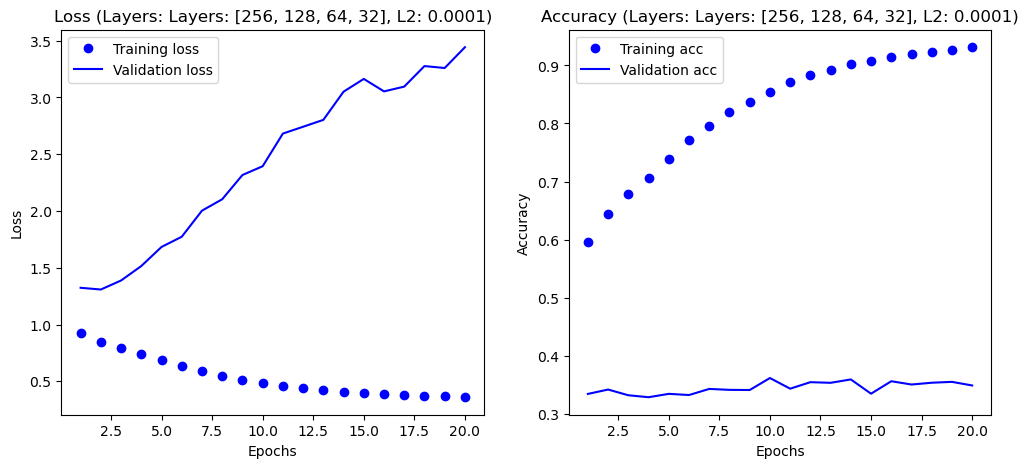

In [45]:
def create_model(layer_config, input_shape, activation='relu', l2_value=0.0):
    model = Sequential()
    model.add(Input(shape=input_shape))  # Explicit input layer
    for nodes in layer_config:
        model.add(Dense(nodes, activation=activation, kernel_regularizer=l2(l2_value)))
    model.add(Dense(3, activation='softmax'))  # Output layer
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def run_experiment_l2(X_train, y_train, X_valid, y_valid, layer_config, l2_value=0.0, epochs=40):
    model = create_model(layer_config, input_shape=(X_train.shape[1],), l2_value=l2_value)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_valid, y_valid))
    plot_history(history, f"Layers: {layer_config}, L2: {l2_value}")
    return history

# Select a model that overfits - [256, 128, 64, 32]
layer_config = [256, 128, 64, 32]

# Run without regularization
print("Training without L2 regularization")
history_no_l2 = run_experiment_l2(X_train, y_train, X_valid, y_valid, layer_config, l2_value=0.0, epochs=20)

# Run with L2 regularization
l2_values = [0.01, 0.001, 1e-4]
histories_l2 = {}
for l2_value in l2_values:
    print(f"\nTraining with L2 regularization (l2={l2_value})")
    history_l2 = run_experiment_l2(X_train, y_train, X_valid, y_valid, layer_config, l2_value=l2_value, epochs=20)
    histories_l2[l2_value] = history_l2


        - Dropout layers are a regularization technique in neural networks where a random subset of neurons is temporarily removed during training. This helps prevent overfitting by promoting redundancy and improving the network's ability to generalize to new data. Select a specific model from the above experiments where you have muliple layers and experiment adding one or of few dropout layers into your network. Experiment with two different rates, say 0.25 and 0.5. Document your observations.

Training without Dropout
Epoch 1/20
1822/1822 [==============================] - 15s 7ms/step - loss: 0.8893 - accuracy: 0.5917 - val_loss: 1.2744 - val_accuracy: 0.3334
Epoch 2/20
1822/1822 [==============================] - 13s 7ms/step - loss: 0.8275 - accuracy: 0.6323 - val_loss: 1.2433 - val_accuracy: 0.3403
Epoch 3/20
1822/1822 [==============================] - 10s 6ms/step - loss: 0.7753 - accuracy: 0.6621 - val_loss: 1.3560 - val_accuracy: 0.3367
Epoch 4/20
1822/1822 [==============================] - 11s 6ms/step - loss: 0.7367 - accuracy: 0.6799 - val_loss: 1.3576 - val_accuracy: 0.3318
Epoch 5/20
1822/1822 [==============================] - 11s 6ms/step - loss: 0.7074 - accuracy: 0.6942 - val_loss: 1.4251 - val_accuracy: 0.3367
Epoch 6/20
1822/1822 [==============================] - 11s 6ms/step - loss: 0.6822 - accuracy: 0.7060 - val_loss: 1.5327 - val_accuracy: 0.3400
Epoch 7/20
1822/1822 [==============================] - 11s 6ms/step - loss: 0.6592 - accuracy: 0.7160 - 

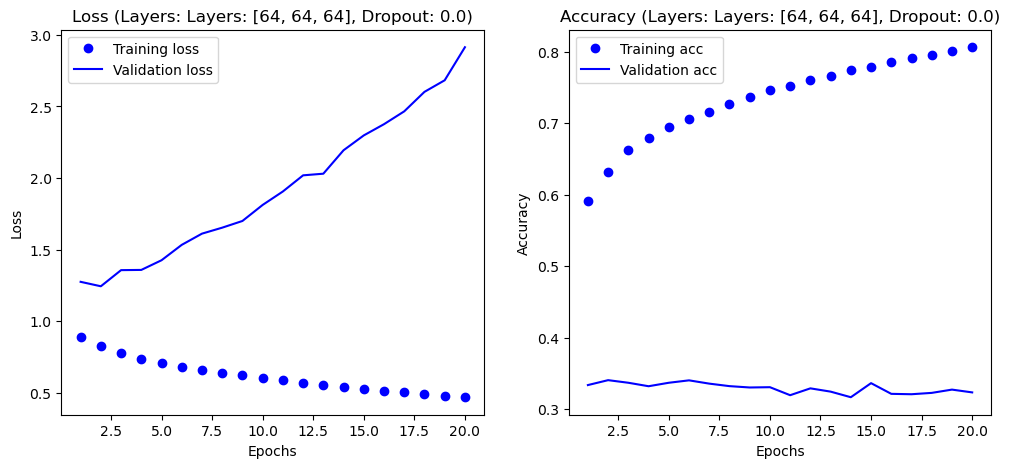


Training with Dropout rate 0.25
Epoch 1/20
1822/1822 [==============================] - 18s 9ms/step - loss: 0.9306 - accuracy: 0.5665 - val_loss: 1.2016 - val_accuracy: 0.3417
Epoch 2/20
1822/1822 [==============================] - 13s 7ms/step - loss: 0.8677 - accuracy: 0.6126 - val_loss: 1.2213 - val_accuracy: 0.3398
Epoch 3/20
1822/1822 [==============================] - 13s 7ms/step - loss: 0.8419 - accuracy: 0.6280 - val_loss: 1.2551 - val_accuracy: 0.3434
Epoch 4/20
1822/1822 [==============================] - 14s 8ms/step - loss: 0.8143 - accuracy: 0.6419 - val_loss: 1.2765 - val_accuracy: 0.3380
Epoch 5/20
1822/1822 [==============================] - 14s 8ms/step - loss: 0.7945 - accuracy: 0.6520 - val_loss: 1.2694 - val_accuracy: 0.3417
Epoch 6/20
1822/1822 [==============================] - 16s 9ms/step - loss: 0.7783 - accuracy: 0.6592 - val_loss: 1.3005 - val_accuracy: 0.3473
Epoch 7/20
1822/1822 [==============================] - 14s 8ms/step - loss: 0.7640 - accuracy: 0

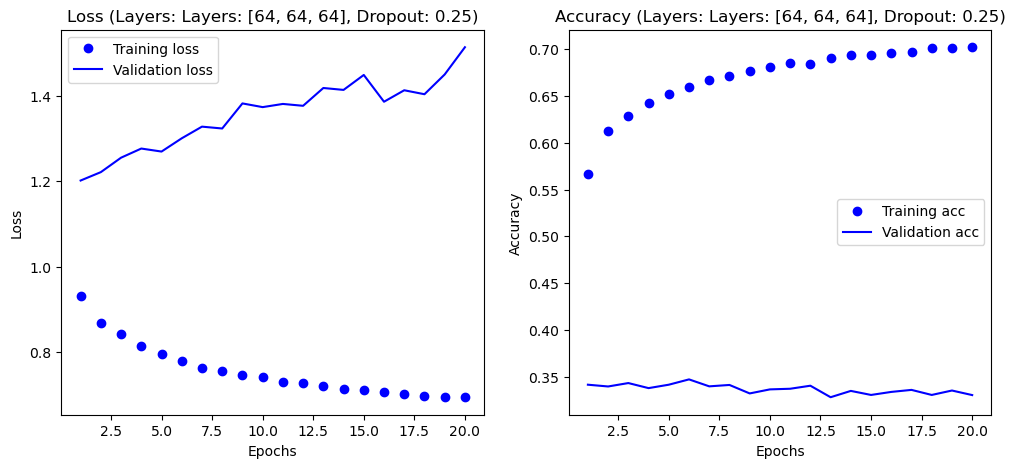


Training with Dropout rate 0.5
Epoch 1/20
1822/1822 [==============================] - 17s 8ms/step - loss: 0.9925 - accuracy: 0.5120 - val_loss: 1.1536 - val_accuracy: 0.3541
Epoch 2/20
1822/1822 [==============================] - 21s 12ms/step - loss: 0.9175 - accuracy: 0.5887 - val_loss: 1.1857 - val_accuracy: 0.3484
Epoch 3/20
1822/1822 [==============================] - 15s 8ms/step - loss: 0.8976 - accuracy: 0.5983 - val_loss: 1.2063 - val_accuracy: 0.3453
Epoch 4/20
1822/1822 [==============================] - 22s 12ms/step - loss: 0.8817 - accuracy: 0.6077 - val_loss: 1.2145 - val_accuracy: 0.3315
Epoch 5/20
1822/1822 [==============================] - 15s 8ms/step - loss: 0.8682 - accuracy: 0.6165 - val_loss: 1.1984 - val_accuracy: 0.3359
Epoch 6/20
1822/1822 [==============================] - 23s 13ms/step - loss: 0.8579 - accuracy: 0.6234 - val_loss: 1.2287 - val_accuracy: 0.3314
Epoch 7/20
1822/1822 [==============================] - 17s 9ms/step - loss: 0.8512 - accuracy:

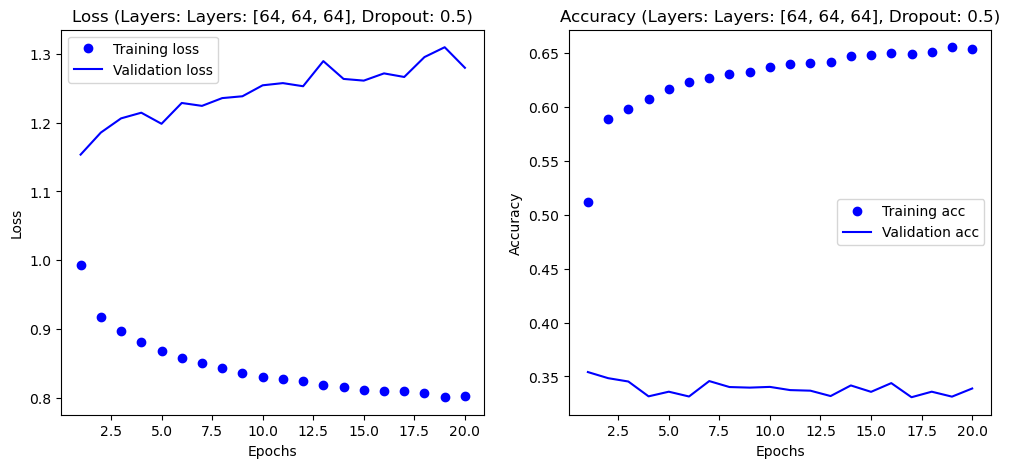

In [46]:
from tensorflow.keras.layers import Dropout

def create_model_with_dropout(layer_config, input_shape, activation='relu', dropout_rate=0.0):
    model = Sequential()
    model.add(Input(shape=input_shape))  # Explicit input layer
    for nodes in layer_config:
        model.add(Dense(nodes, activation=activation))
        if dropout_rate > 0.0:
            model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax'))  # Output layer
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def run_experiment_dropout(X_train, y_train, X_valid, y_valid, layer_config, dropout_rate=0.0, epochs=20):
    model = create_model_with_dropout(layer_config, input_shape=(X_train.shape[1],), dropout_rate=dropout_rate)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_valid, y_valid))
    plot_history(history, f"Layers: {layer_config}, Dropout: {dropout_rate}")
    return history

# Run experiments
layer_config = [64, 64, 64]

# Without dropout
print("Training without Dropout")
history_no_dropout = run_experiment_dropout(X_train, y_train, X_valid, y_valid, layer_config, dropout_rate=0.0, epochs=20)

# With dropout rates 0.25 and 0.5
dropout_rates = [0.25, 0.5]
histories_dropout = {}
for rate in dropout_rates:
    print(f"\nTraining with Dropout rate {rate}")
    history_dropout = run_experiment_dropout(X_train, y_train, X_valid, y_valid, layer_config, dropout_rate=rate, epochs=20)
    histories_dropout[rate] = history_dropout


        - Summarize your experiments with using a graphical representation such as Figure 6.15 [on this page](https://egallic.fr/Enseignement/ML/ECB/book/deep-learning.html).

In [47]:
# Graphical Summary

# Let's first collect the histories from different experiments
histories = {}

# Define the configurations we want to compare
configurations = {
    'Baseline NN': {'layers': [64, 64, 64], 'activation': 'relu', 'l2_value': 0.0, 'dropout_rate': 0.0},
    'L2 Regularization (0.001)': {'layers': [64, 64, 64], 'activation': 'relu', 'l2_value': 0.001, 'dropout_rate': 0.0},
    'Dropout (0.25)': {'layers': [64, 64, 64], 'activation': 'relu', 'l2_value': 0.0, 'dropout_rate': 0.25},
    'Activation Function (Sigmoid)': {'layers': [64, 64, 64], 'activation': 'sigmoid', 'l2_value': 0.0, 'dropout_rate': 0.0},
    'Combined Regularization': {'layers': [64, 64, 64], 'activation': 'relu', 'l2_value': 0.001, 'dropout_rate': 0.25},
}

# Import EarlyStopping to prevent unnecessary long training
from tensorflow.keras.callbacks import EarlyStopping

# Function to create the model with various configurations
def create_model_full(layer_config, input_shape, activation='relu', l2_value=0.0, dropout_rate=0.0):
    model = Sequential()
    model.add(Input(shape=input_shape))
    for nodes in layer_config:
        model.add(Dense(nodes, activation=activation, kernel_regularizer=l2(l2_value)))
        if dropout_rate > 0.0:
            model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Train models with different configurations and store their histories
for config_name, params in configurations.items():
    print(f"\nTraining Model: {config_name}")
    model = create_model_full(
        layer_config=params['layers'],
        input_shape=(X_train.shape[1],),
        activation=params['activation'],
        l2_value=params['l2_value'],
        dropout_rate=params['dropout_rate']
    )
    # Using EarlyStopping to ensure models don't overfit excessively during training
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_valid, y_valid),
        callbacks=[early_stopping],
        verbose=0  # Suppress output for clarity
    )
    histories[config_name] = history


Training Model: Baseline NN

Training Model: L2 Regularization (0.001)

Training Model: Dropout (0.25)

Training Model: Activation Function (Sigmoid)

Training Model: Combined Regularization


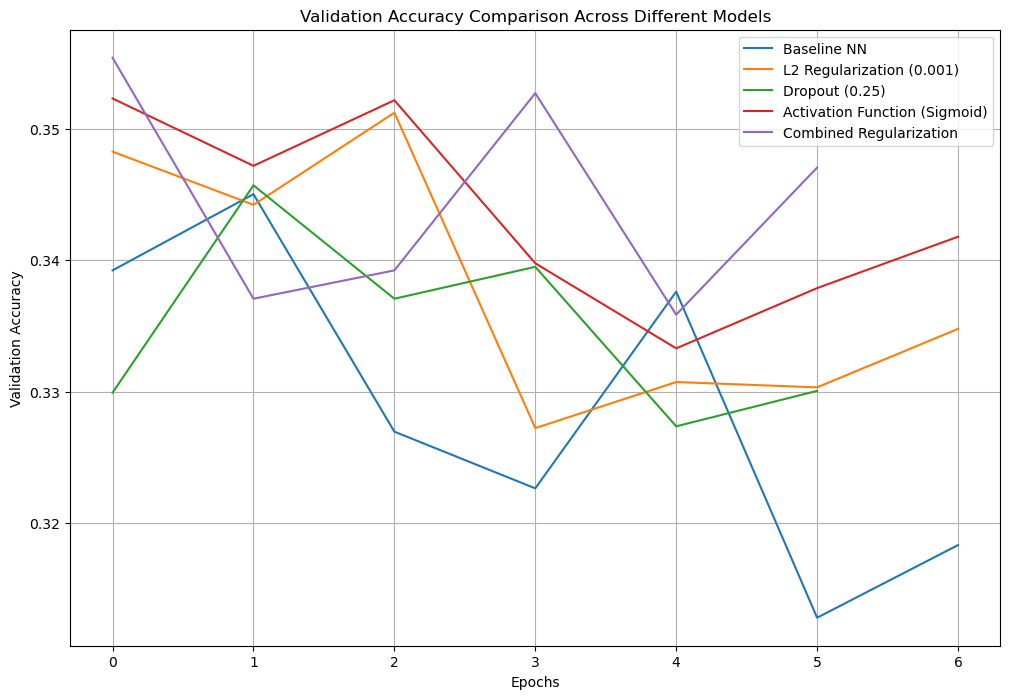

In [48]:
# Plotting the Validation Accuracy for Different Models:

plt.figure(figsize=(12, 8))

for config_name, history in histories.items():
    plt.plot(history.history['val_accuracy'], label=config_name)

plt.title('Validation Accuracy Comparison Across Different Models')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


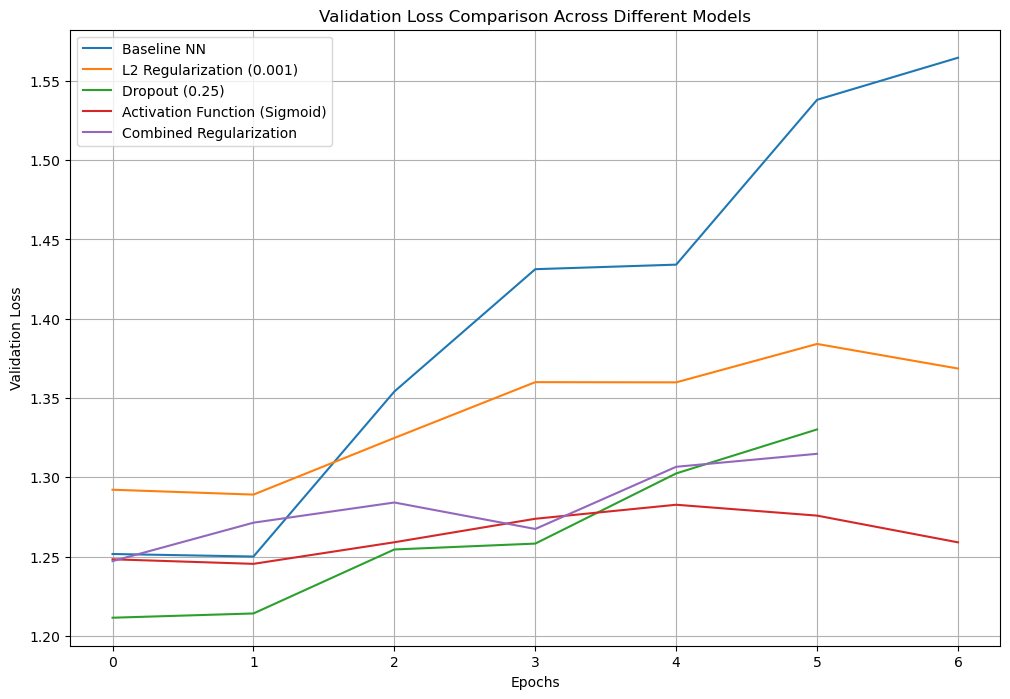

In [49]:
# Plotting the Validation Loss for Different Models:

plt.figure(figsize=(12, 8))

for config_name, history in histories.items():
    plt.plot(history.history['val_loss'], label=config_name)

plt.title('Validation Loss Comparison Across Different Models')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

        - Early stopping is a regularization technique in neural network training wherein the process is halted when validation set performance starts to decline, thus preventing overfitting by avoiding the learning of noise in the training data. From all the experiments conducted thus far, choose **one** configuration (the number of layers, number of nodes, activation function, L2 penalty, and dropout layers) that yielded the best performance. Use a graph of loss and accuracy to determine the optimal number of training iterations for this network. What is the optimal number of epochs for this network configuration and why?

Epoch 1/20
1822/1822 [==============================] - 14s 7ms/step - loss: 0.9746 - accuracy: 0.5909 - val_loss: 1.2795 - val_accuracy: 0.3410
Epoch 2/20
1822/1822 [==============================] - 12s 6ms/step - loss: 0.8968 - accuracy: 0.6172 - val_loss: 1.3233 - val_accuracy: 0.3442
Epoch 3/20
1822/1822 [==============================] - 12s 6ms/step - loss: 0.8682 - accuracy: 0.6390 - val_loss: 1.2932 - val_accuracy: 0.3573
Epoch 4/20
1822/1822 [==============================] - 20s 11ms/step - loss: 0.8518 - accuracy: 0.6488 - val_loss: 1.3401 - val_accuracy: 0.3533
Epoch 5/20
1822/1822 [==============================] - 11s 6ms/step - loss: 0.8391 - accuracy: 0.6553 - val_loss: 1.3104 - val_accuracy: 0.3408
Epoch 6/20
1822/1822 [==============================] - 12s 7ms/step - loss: 0.8321 - accuracy: 0.6622 - val_loss: 1.3513 - val_accuracy: 0.3502


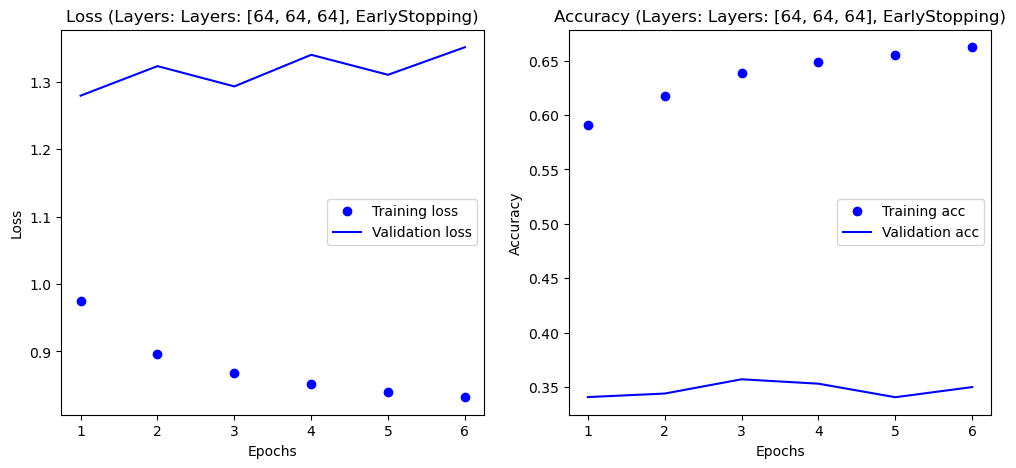

In [50]:
def run_experiment_with_early_stopping(X_train, y_train, X_valid, y_valid, layer_config, epochs=100, patience=5):
    model = create_model(layer_config, input_shape=(X_train.shape[1],), l2_value=0.001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_valid, y_valid), callbacks=[early_stopping])
    plot_history(history, f"Layers: {layer_config}, EarlyStopping")
    return history

# Run the experiment
layer_config = [64, 64, 64]
history_early_stopping = run_experiment_with_early_stopping(X_train, y_train, X_valid, y_valid, layer_config, epochs=20, patience=5)


### Test

9. **Model Comparison**:

    - Evaluate the baseline model on the test set, using the optimal parameter set identified through grid search. Additionally, apply your best-performing neural network configuration to the test set.

    - Quantify the performance of the baseline model (best hyperparameter configuration) and your neural network (best configuration) using precision, recall, and F1-score as metrics. How do these two models compare to the dummy model?

    - Provide recommendations on which model(s) to choose for this task and justify your choices based on the analysis results.

In [51]:
#Baseline Model Evaluation: Retrain Logistic Regression with best hyperparameters
best_params = grid_search.best_params_
best_baseline_clf = LogisticRegression(**best_params)
best_baseline_clf.fit(X_train, y_train)

# Evaluate on test set
y_pred_baseline = best_baseline_clf.predict(X_test)

In [52]:
# Neural Network Evaluation:


# Combine training and validation data
X_train_full = pd.concat([X_train, X_valid], axis=0)
y_train_full = pd.concat([y_train, y_valid], axis=0)

# Retrain neural network with best configuration
best_layer_config = [64, 64, 64]
best_model = create_model(best_layer_config, input_shape=(X_train_full.shape[1],), l2_value=0.001)
best_model.fit(X_train_full, y_train_full, epochs=20, batch_size=32)

# Evaluate on test set
y_pred_nn = best_model.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

Epoch 1/20
2054/2054 [==============================] - 16s 6ms/step - loss: 0.9900 - accuracy: 0.5690
Epoch 2/20
2054/2054 [==============================] - 20s 10ms/step - loss: 0.9179 - accuracy: 0.6065
Epoch 3/20
2054/2054 [==============================] - 11s 6ms/step - loss: 0.8881 - accuracy: 0.6305
Epoch 4/20
2054/2054 [==============================] - 10s 5ms/step - loss: 0.8275 - accuracy: 0.6718
Epoch 12/20
2054/2054 [==============================] - 19s 9ms/step - loss: 0.8242 - accuracy: 0.6767
Epoch 13/20
2054/2054 [==============================] - 10s 5ms/step - loss: 0.8228 - accuracy: 0.6751
Epoch 14/20
2054/2054 [==============================] - 11s 6ms/step - loss: 0.8196 - accuracy: 0.6788
Epoch 15/20
2054/2054 [==============================] - 19s 9ms/step - loss: 0.8180 - accuracy: 0.6804
Epoch 16/20
2054/2054 [==============================] - 11s 5ms/step - loss: 0.8163 - accuracy: 0.6795
Epoch 17/20
2054/2054 [==============================] - 12s 6ms/st

In [53]:
# Dummy Model Evaluation
dummy_predictions_test = dummy_clf.predict(X_test)

In [54]:
# Performance Metrics: 

# Baseline model metrics
print("Baseline Model Performance:")
print(classification_report(y_test, y_pred_baseline, digits=4))

# Neural network metrics
print("Neural Network Performance:")
print(classification_report(y_test, y_pred_nn_classes, digits=4))

# Dummy model metrics
print("Dummy Model Performance:")
print(classification_report(y_test, dummy_predictions_test, digits=4))

Baseline Model Performance:
              precision    recall  f1-score   support

           0     0.3319    0.2508    0.2857      2528
           1     0.2611    0.1771    0.2111      1852
           2     0.4103    0.5736    0.4784      3051

    accuracy                         0.3650      7431
   macro avg     0.3345    0.3338    0.3251      7431
weighted avg     0.3465    0.3650    0.3462      7431

Neural Network Performance:
              precision    recall  f1-score   support

           0     0.3736    0.2694    0.3130      2528
           1     0.2605    0.1274    0.1711      1852
           2     0.4132    0.6368    0.5012      3051

    accuracy                         0.3849      7431
   macro avg     0.3491    0.3446    0.3285      7431
weighted avg     0.3617    0.3849    0.3549      7431

Dummy Model Performance:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      2528
           1     0.0000    0.0000    0.0000     

C:\Users\User\anaconda3\envs\dsl\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\envs\dsl\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\envs\dsl\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 2. Documentation of Exploratory Analysis

- If you worked in pairs during the assignment, explain how the tasks have been split between the members. How did you make sure that both students achieve the learning outcomes? 

Ans: I (Rahul) spent a lot of time working on the data pre-processing steps, like performing cross-validation and evaluating the models at the end. For the neural network stage, I assisted Jacob in the L2 regularization tasks which helped reduce overfitting. Jacob on the other hand, took the lead in developing the neural network models and experimenting with the number of nodes in the hidden layers. He made the graphical representations, and performed experiments with the different activation functions. To ensure learning outcomes, we had regular meetings and collaborated using github to share code and results. We both spent an equal amount of time reviewing and editing each others explanations to ensure completeness. 

# Resources

**sklearn**

DummyClassifier: https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier

Grid Search: https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html

Model Evaluation: https://scikit-learn.org/1.5/modules/model_evaluation.html


**Tensorflow**

General: https://www.tensorflow.org/api_docs/python/tf/all_symbols

L2 Regulization: https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/L2

Dropout: https://www.geeksforgeeks.org/implementing-dropout-in-tensorflow/

Dense: https://keras.io/2.15/api/layers/core_layers/dense/

https://msalamiitd.medium.com/demystifying-model-architectures-in-tensorflow-a-comprehensive-guide-60393d8fa684

## AI transcript


